In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        globals()[filename.split('.')[0]] = pd.read_csv(dirname+'/'+filename)
        print(filename)

customeraccount.csv
sample_submission.csv
transaction_header.csv
genel_kategoriler.csv
customer.csv
train.csv
test.csv
product_groups.csv
transaction_sale.csv


In [4]:
import numpy as np 

import optuna
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold, KFold,train_test_split
import datetime
from datetime import date
from collections import Counter
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score,mean_squared_error
from itertools import combinations
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor


pd.options.display.max_rows=250
pd.options.display.max_columns=250
pd.options.display.max_colwidth=25
cm = sns.light_palette("red", as_cmap=True)

def null_rate(df):
    return (df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'}).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm, tqdm_notebook
# from tqdm._tqdm_notebook import tqdm_notebook
tqdm.pandas(desc="my bar!")

import warnings
warnings.filterwarnings('ignore')



def calculate_optimum_threshold(y_true, y_pred_labels):
    max_thresh = 0.3
    max_score = 0
    for thresh in range(30, 60, 2):
        thresh = thresh / 100
        y_pred = (y_pred_labels > thresh).astype('int')
        score = f1_score(y_true, y_pred)
        if score >= max_score:
            max_score = score
            max_thresh = thresh
        if y_pred.sum()/y_pred.shape[0] < 0.005:
            continue
    print(f"Optimum threshold: {max_thresh}, Score: {max_score}")
    return max_thresh, max_score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels
    Parameters
    ----------
    y_true (numpy.ndarray of shape (n_samples)): Ground truth labels
    y_pred (numpy.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    scores (dict): Dictionary of calculated scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
#         'accuracy': accuracy_score(y_true, y_pred_labels),
#         'roc_auc': roc_auc_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred_labels),
#         'recall': recall_score(y_true, y_pred_labels),
        'f1': f1_score(y_true, y_pred_labels),
#         'pos_rate': f"{y_pred_labels.sum()}/{y_pred_labels.shape[0]}"
    }

    return scores

def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold
    Parameters
    ----------
    probabilities (np.ndarray of shape (n_samples)): Predicted probabilities
    threshold (float): Rounding threshold
    Returns
    -------
    labels (numpy.ndarray of shape (n_samples)): Labels
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels

# Data Preview

### 1-customerAccount

In [5]:
customeraccount=customeraccount.astype({'individualnumber':'object','cardnumber':'object'})
customeraccount.info()
# print(f'memory useage :',customeraccount.memory_usage().sum()/1024/1024,f'MB')
customeraccount.groupby('individualnumber')['cardnumber'].count().to_frame().sort_values('cardnumber',ascending=False)[:50].style.background_gradient(cmap=cm)

print(f'customeraccount null rate.')
null_rate(customeraccount)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35159 entries, 0 to 35158
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   individualnumber  35159 non-null  object
 1   cardnumber        35159 non-null  object
dtypes: object(2)
memory usage: 549.5+ KB


,cardnumber
individualnumber,
96035559,49
13936527,25
98338349,21
7923458,17
10817264,17
92455160,16
92472145,16
89086894,15
42273372,15


customeraccount null rate.


,null_rate
individualnumber,0.000000
cardnumber,0.000000


### 2-customer

In [6]:
customer=customer.astype({'individualnumber':'object','city_code':'object'})
customer.info()
null_rate(customer)
customer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28593 entries, 0 to 28592
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  28593 non-null  object 
 1   gender            28588 non-null  object 
 2   city_code         21886 non-null  object 
 3   dateofbirth       28578 non-null  float64
dtypes: float64(1), object(3)
memory usage: 893.7+ KB


,null_rate
city_code,0.234568
dateofbirth,0.000525
gender,0.000175
individualnumber,0.000000


,individualnumber,gender,city_code,dateofbirth
0,94212124,K,NaN,1946.0
1,96387515,E,34.0,1974.0
2,95040383,E,80.0,1980.0
3,94694434,E,NaN,1970.0
4,47648671,E,35.0,1963.0
...,...,...,...,...
28588,94368469,K,34.0,1948.0
28589,90691477,E,7.0,1990.0
28590,95834384,E,22.0,1970.0
28591,92199848,E,34.0,1985.0


### 3-train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13115 entries, 0 to 13114
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13115 non-null  object 
 1   category_number   13115 non-null  object 
 2   hakkedis_amt      13115 non-null  float64
 3   odul_amt          13115 non-null  float64
 4   response          13115 non-null  float64
dtypes: float64(3), object(2)
memory usage: 512.4+ KB


<AxesSubplot:xlabel='category_number', ylabel='count'>

[Text(0, 0, '9046'),
 Text(1, 0, '9000'),
 Text(2, 0, '9022'),
 Text(3, 0, '9035'),
 Text(4, 0, '9017'),
 Text(5, 0, '9006'),
 Text(6, 0, '9038'),
 Text(7, 0, '9019'),
 Text(8, 0, '9039'),
 Text(9, 0, '9036'),
 Text(10, 0, '9059'),
 Text(11, 0, '9027'),
 Text(12, 0, '9003'),
 Text(13, 0, '9018'),
 Text(14, 0, '9032'),
 Text(15, 0, '9058'),
 Text(16, 0, '9049'),
 Text(17, 0, '9004'),
 Text(18, 0, '9043'),
 Text(19, 0, '9029'),
 Text(20, 0, '9008'),
 Text(21, 0, '9044'),
 Text(22, 0, '9021'),
 Text(23, 0, '9001'),
 Text(24, 0, '9048'),
 Text(25, 0, '9012'),
 Text(26, 0, '9007'),
 Text(27, 0, '9020'),
 Text(28, 0, '9010'),
 Text(29, 0, '9037'),
 Text(30, 0, '9042'),
 Text(31, 0, '9040'),
 Text(32, 0, '9024'),
 Text(33, 0, '9041'),
 Text(34, 0, '9056'),
 Text(35, 0, '9055'),
 Text(36, 0, '9015'),
 Text(37, 0, '9060'),
 Text(38, 0, '9030'),
 Text(39, 0, '9053'),
 Text(40, 0, '9009'),
 Text(41, 0, '9031'),
 Text(42, 0, '9061'),
 Text(43, 0, '9005'),
 Text(44, 0, '9002'),
 Text(45, 0, '9011')

<AxesSubplot:xlabel='response', ylabel='count'>

<AxesSubplot:xlabel='hakkedis_amt', ylabel='Count'>

<AxesSubplot:xlabel='odul_amt', ylabel='Count'>

,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000
response,0.000000


,individualnumber,category_number,hakkedis_amt,odul_amt,response
0,94230288,9000,21.0,2.0,0.0
1,4684087,9000,17.0,1.0,0.0
2,92472145,9058,24.0,3.0,0.0
3,88026681,9030,22.0,2.0,0.0
4,98127795,9001,38.0,3.0,0.0
...,...,...,...,...,...
13110,97214433,9059,27.0,2.0,0.0
13111,96841665,9004,65.0,6.0,0.0
13112,98445787,9044,33.0,3.0,0.0
13113,13781030,9004,66.0,6.0,0.0


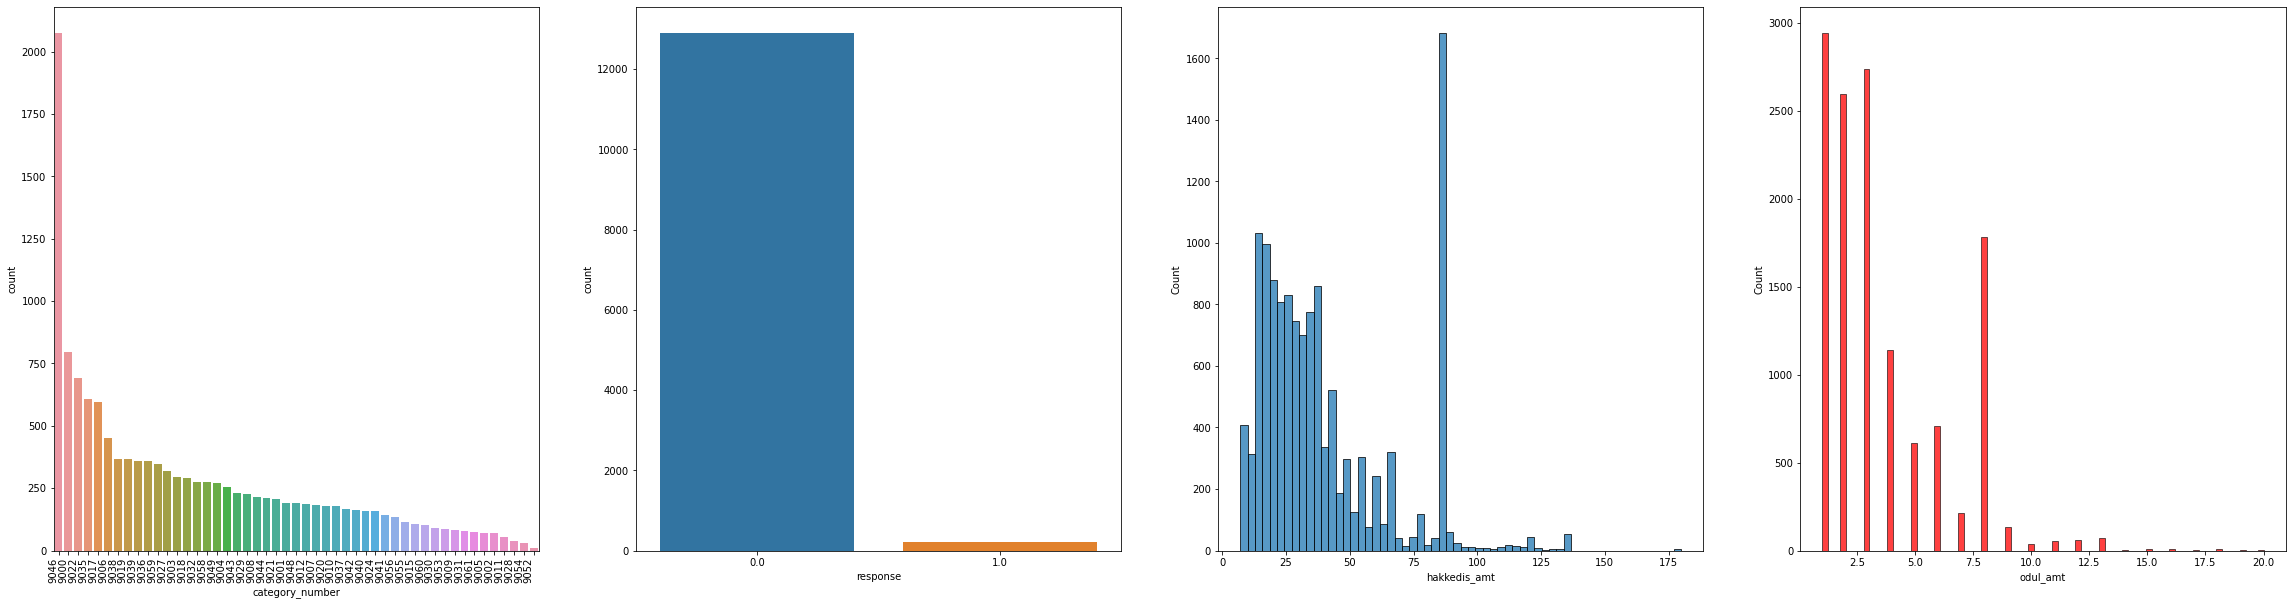

In [7]:
train=train.astype({'individualnumber':'object','category_number':'object','response':'float'})
train.info()

f,ax=plt.subplots(1,4,figsize=[40,10])
sns.countplot(train.category_number,order=train.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.countplot(train.response,ax=ax[1]);
sns.histplot(train.hakkedis_amt,ax=ax[2]);
sns.histplot(train.odul_amt,ax=ax[3],color='r');

null_rate(train)

train

### 3-test

,null_rate
individualnumber,0.000000
category_number,0.000000
hakkedis_amt,0.000000
odul_amt,0.000000


<AxesSubplot:xlabel='category_number', ylabel='count'>

[Text(0, 0, '9046'),
 Text(1, 0, '9000'),
 Text(2, 0, '9022'),
 Text(3, 0, '9035'),
 Text(4, 0, '9017'),
 Text(5, 0, '9006'),
 Text(6, 0, '9039'),
 Text(7, 0, '9038'),
 Text(8, 0, '9059'),
 Text(9, 0, '9019'),
 Text(10, 0, '9036'),
 Text(11, 0, '9032'),
 Text(12, 0, '9058'),
 Text(13, 0, '9027'),
 Text(14, 0, '9049'),
 Text(15, 0, '9018'),
 Text(16, 0, '9003'),
 Text(17, 0, '9004'),
 Text(18, 0, '9043'),
 Text(19, 0, '9044'),
 Text(20, 0, '9029'),
 Text(21, 0, '9001'),
 Text(22, 0, '9007'),
 Text(23, 0, '9008'),
 Text(24, 0, '9048'),
 Text(25, 0, '9020'),
 Text(26, 0, '9021'),
 Text(27, 0, '9012'),
 Text(28, 0, '9010'),
 Text(29, 0, '9040'),
 Text(30, 0, '9024'),
 Text(31, 0, '9042'),
 Text(32, 0, '9037'),
 Text(33, 0, '9056'),
 Text(34, 0, '9041'),
 Text(35, 0, '9055'),
 Text(36, 0, '9060'),
 Text(37, 0, '9015'),
 Text(38, 0, '9053'),
 Text(39, 0, '9030'),
 Text(40, 0, '9061'),
 Text(41, 0, '9002'),
 Text(42, 0, '9011'),
 Text(43, 0, '9031'),
 Text(44, 0, '9005'),
 Text(45, 0, '9009')

<AxesSubplot:xlabel='hakkedis_amt', ylabel='Count'>

<AxesSubplot:xlabel='odul_amt', ylabel='Count'>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   individualnumber  13236 non-null  object 
 1   category_number   13236 non-null  object 
 2   hakkedis_amt      13236 non-null  float64
 3   odul_amt          13236 non-null  float64
dtypes: float64(2), object(2)
memory usage: 413.8+ KB


,individualnumber,category_number,hakkedis_amt,odul_amt
0,95812936,9029,38.0,3.0
1,23929570,9012,28.0,2.0
2,95948115,9019,21.0,2.0
3,100898513,9035,48.0,4.0
4,12769156,9015,26.0,3.0
...,...,...,...,...
13231,93418529,9049,32.0,3.0
13232,97397069,9018,20.0,2.0
13233,95212479,9046,85.0,8.0
13234,93406449,9032,39.0,3.0


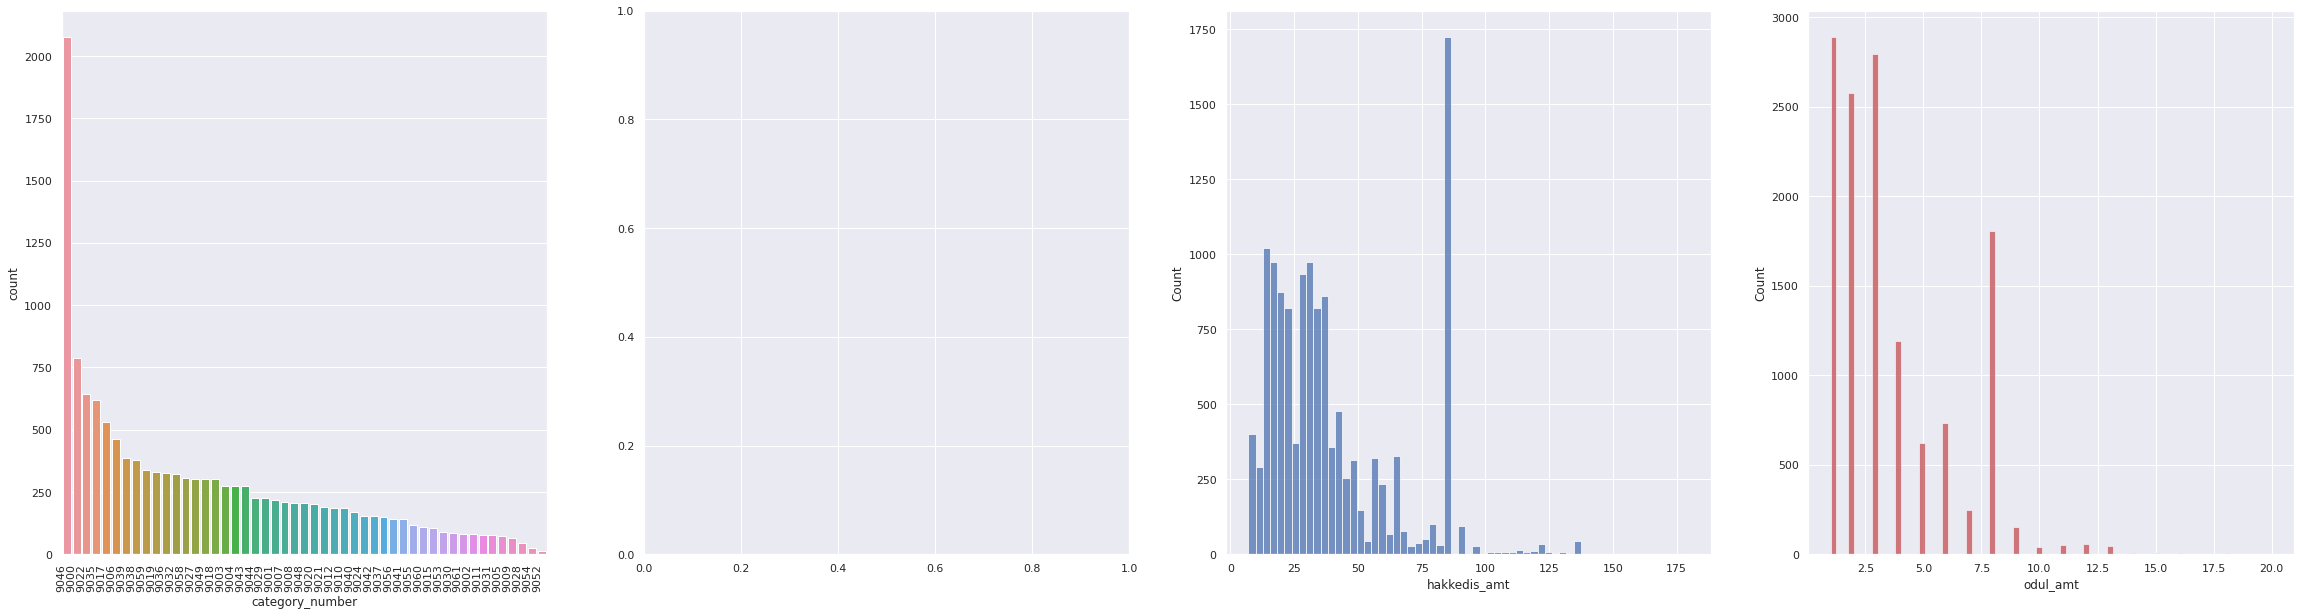

In [8]:
test=test.astype({'individualnumber':'object','category_number':'object'})
null_rate(test)
sns.set(context="paper", font="monospace");
sns.set(rc={'figure.figsize':(11.7,8.27)});
f,ax=plt.subplots(1,4,figsize=[40,10]);
sns.countplot(test.category_number,order=test.category_number.value_counts().index,ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90,horizontalalignment='right');
sns.histplot(test.hakkedis_amt,ax=ax[2]);
sns.histplot(test.odul_amt,ax=ax[3],color='r');
test.info()
test


### 4-product_groups

In [9]:
product_groups=product_groups.astype({'category_number':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
product_groups.info()
null_rate(product_groups)
product_groups

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category_number   3913 non-null   object
 1   category_level_1  3913 non-null   object
 2   category_level_2  3913 non-null   object
 3   category_level_3  3913 non-null   object
 4   category_level_4  3913 non-null   object
dtypes: object(5)
memory usage: 153.0+ KB


,null_rate
category_number,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000


,category_number,category_level_1,category_level_2,category_level_3,category_level_4
0,9046,341,20,10,10
1,9009,125,25,10,10
2,9049,410,65,20,10
3,9019,300,10,19,11
4,9035,305,31,10,10
...,...,...,...,...,...
3908,9019,616,95,20,15
3909,9020,616,95,20,10
3910,9020,616,95,20,15
3911,9020,616,95,20,30


### 5-transaction_sale

In [10]:
transaction_sale=transaction_sale.astype({'basketid':'object','category_level_1':'object','category_level_2':'object','category_level_3':'object','category_level_4':'object'})
transaction_sale.info()
# transaction_sale.drop(transaction_sale[(transaction_sale.amount<1)|(transaction_sale.amount>10000)].index,inplace=True)
null_rate(transaction_sale)
transaction_sale['amt_quantity_rate']=transaction_sale.amount/transaction_sale.quantity
transaction_sale['sum_discount_type']=transaction_sale[['discount_type_1','discount_type_2', 'discount_type_3']].sum(axis=1)
transaction_sale

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537881 entries, 0 to 6537880
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   basketid          object 
 1   category_level_1  object 
 2   category_level_2  object 
 3   category_level_3  object 
 4   category_level_4  object 
 5   amount            float64
 6   quantity          float64
 7   discount_type_1   float64
 8   discount_type_2   float64
 9   discount_type_3   float64
dtypes: float64(5), object(5)
memory usage: 498.8+ MB


,null_rate
discount_type_1,0.711067
discount_type_2,0.000020
discount_type_3,0.000020
basketid,0.000000
category_level_1,0.000000
category_level_2,0.000000
category_level_3,0.000000
category_level_4,0.000000
amount,0.000000
quantity,0.000000


,basketid,category_level_1,category_level_2,category_level_3,category_level_4,amount,quantity,discount_type_1,discount_type_2,discount_type_3,amt_quantity_rate,sum_discount_type
0,20120706070177471,613,50,50,15,19.90,2.0,NaN,0.0,0.00,9.95,0.00
1,20120706070177471,425,30,12,10,3.50,1.0,NaN,0.0,0.00,3.50,0.00
2,20120706070177471,425,30,12,11,7.90,1.0,NaN,0.0,0.00,7.90,0.00
3,20122703940031323,103,25,15,10,7.90,2.0,NaN,0.0,0.00,3.95,0.00
4,20122703940031323,101,15,15,15,16.00,1.0,NaN,0.0,0.00,16.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6537876,20120839080026509,103,35,10,10,2.95,1.0,NaN,0.0,0.00,2.95,0.00
6537877,20120839080026509,130,85,11,10,3.40,1.0,NaN,0.0,0.00,3.40,0.00
6537878,20120839080026509,131,10,10,20,4.45,1.0,NaN,0.0,0.00,4.45,0.00
6537879,21101831040099839,103,35,10,10,0.01,1.0,NaN,0.0,1.24,0.01,1.24


### 6-transaction_header

In [11]:
transaction_header=transaction_header.astype({'date_of_transaction':'datetime64','cardnumber':'object','basketid':'object','is_sanal':'object'})
transaction_header.info()
null_rate(transaction_header)

transaction_header['month']=transaction_header.date_of_transaction.dt.month
transaction_header['year']=transaction_header.date_of_transaction.dt.year
transaction_header['day']=transaction_header.date_of_transaction.dt.day
transaction_header['day_of_weak']=transaction_header.date_of_transaction.dt.dayofweek

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124673 entries, 0 to 1124672
Data columns (total 4 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date_of_transaction  1124673 non-null  datetime64[ns]
 1   cardnumber           1124673 non-null  object        
 2   basketid             1124673 non-null  object        
 3   is_sanal             1124673 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 34.3+ MB


,null_rate
date_of_transaction,0.000000
cardnumber,0.000000
basketid,0.000000
is_sanal,0.000000


### genel_kategoriler

In [12]:
genel_kategoriler=genel_kategoriler.astype({'category_number':'object'})
genel_kategoriler.info()
null_rate(genel_kategoriler)
genel_kategoriler.head()
print('   ')
print(f'genel_kategoriler shape : ',genel_kategoriler.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category_number  50 non-null     object
 1   genel_kategori   50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes


,null_rate
category_number,0.000000
genel_kategori,0.000000


,category_number,genel_kategori
0,9052,diger
1,9053,diger
2,9054,diger
3,9055,gida
4,9056,gida


   
genel_kategoriler shape :  (50, 2)


## Some Data preprocessing stages

In [13]:
cinfo=customer.merge(customeraccount,on='individualnumber')
cinfo.loc[cinfo.city_code.isnull(),'city_code']='unknown'
cinfo.loc[cinfo.gender.isnull(),'gender']='E'
cinfo.loc[cinfo.dateofbirth.isnull(),'dateofbirth']=round(cinfo.dateofbirth.mean())
#----------------------------------------------------------------------
test=sample_submission.merge(test,how='left',on='individualnumber').drop('response',axis=1)
#----------------------------------------------------------------------
df_train_test=pd.concat([train,test],axis=0)
#----------------------------------------------------------------------
df_train_test['odul_amt_hakkedis_amt']=df_train_test.odul_amt/df_train_test.hakkedis_amt
dum=df_train_test.groupby('category_number').odul_amt_hakkedis_amt.mean().to_frame().rename(columns={'odul_amt_hakkedis_amt':'odul_amt_hakkedis_amt_gb'})
df_train_test=df_train_test.merge(dum,how='left',on='category_number')

#----------------------------------------------------------------------
transaction_sale.drop(transaction_sale[(transaction_sale.discount_type_3<0)|(transaction_sale.sum_discount_type<0)].index,inplace=True)
transaction_sale.drop(transaction_sale[(transaction_sale.discount_type_3>50)|(transaction_sale.discount_type_2>50)|(transaction_sale.discount_type_1>50)].index,inplace=True)
#----------------------------------------------------------------------

print(f'Train shape :',train.shape)
print(f'Test shape:',test.shape)
#----------------------------------------------------------------------
cinfo=cinfo[cinfo.individualnumber.isin(df_train_test.individualnumber)] # in here ,We are selecting only individualnumber of df_train_test inside from cinfo dataframe
cinfo=cinfo[cinfo.cardnumber.isin(transaction_header.cardnumber)]
df_train_test=df_train_test.merge(cinfo,on='individualnumber')
df_train_test.loc[df_train_test.hakkedis_amt>140,'hakkedis_amt']=140

# -----------------------------------------------------------------
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')

Train shape : (13115, 5)
Test shape: (13236, 4)


In [14]:
from sklearn.cluster import KMeans
dum_df=transaction_sale[['category_level_1','category_level_2','category_level_3','category_level_4']]
dum_df=dum_df.astype({'category_level_1':str,'category_level_2':str,'category_level_3':str,'category_level_4':str})
kmeans = KMeans(n_clusters=20, random_state=0).fit(dum_df)
gc.collect()
transaction_sale['category_labels']=kmeans.labels_

25413

In [15]:
transaction_header=transaction_header[transaction_header.cardnumber.isin(df_train_test.cardnumber)]
transaction_sale['discount_mul']=transaction_sale.discount_type_1.replace(0,1).fillna(1).mul(transaction_sale.discount_type_2.replace(0,1).fillna(1)).mul(transaction_sale.discount_type_3.replace(0,1).fillna(1))
data=df_train_test.merge(transaction_header.merge(transaction_sale,on='basketid'),on='cardnumber')  #transaction_sale and transaction_Header merged over baskedid  then merged df_train_test over cardnumber
data=data.merge(genel_kategoriler,on='category_number')
data=pd.concat([data,pd.get_dummies(data.genel_kategori)],axis=1)
data=pd.concat([data,pd.get_dummies(data.category_labels)],axis=1)
data.discount_type_1.fillna(data.discount_type_1.median(),inplace=True)
data.discount_type_2.fillna(data.discount_type_2.median(),inplace=True)
data.discount_type_3.fillna(data.discount_type_3.median(),inplace=True)
gc.collect()

0

In [16]:
data=data.groupby('individualnumber').agg(
gender=('gender','first'),
city_code=('city_code','first'),
dateofbirth=('dateofbirth','first'),
sum_amount=('amount','sum'),  
mean_amount=('amount','mean'),
quantity_sum=('quantity','mean'),
diger_amount=('diger','sum'),    
gida_amount=('gida','sum'),    
hijyen_amount=('hijyen','sum'),
icecek_amount=('icecek','sum'),    
kisisel_bakim_amount=('kisisel_bakim','sum'),    
is_sanal_sayısı=('is_sanal','count'), 
basket_sayısı=('basketid','count'), 
discount_type_1_toplam=('discount_type_1','sum'), 
discount_type_2_toplam=('discount_type_2','sum'), 
discount_type_3_toplam=('discount_type_3','sum'),
day_of_weak_freq=('day_of_weak',lambda x:x.value_counts().index[0]),
day_freq=('day',lambda x:x.value_counts().index[0]),
month_freq=('month',lambda x:x.value_counts().index[0]),
date_diff=('date_of_transaction',lambda x:(x.max()-x.min()).days),
hakkedis_amt=('hakkedis_amt','first'), 
response=('response','first'), 
odul_amt_hakkedis_amt=('odul_amt_hakkedis_amt','first'), 
odul_amt=('odul_amt','count'), 
odul_amt_hakkedis_amt_gb=('odul_amt_hakkedis_amt_gb','first'), 
# category_number=('category_number','first'),
sum_discount_type=('sum_discount_type','sum'),
sum_discount_mul=('discount_mul','sum'),

    
L_0=(0,'sum'),         
L_1=(1,'sum') ,    
L_2=(2,'sum')  ,
L_3=(3,'sum')  ,
L_4=(4,'sum')   ,
L_5=(5,'sum')  ,
L_6=(6,'sum')  ,
L_7=(7,'sum')  ,
L_8=(8,'sum')  ,
L_9=(9,'sum')  ,
L_10=(10,'sum') , 
L_11=(11,'sum')  ,
L_12=(12,'sum')  ,     
L_13=(13,'sum')  ,
L_14=(14,'sum')  ,
L_15=(15,'sum')  ,
L_16=(16,'sum')  ,
L_17=(17,'sum')  ,
L_18=(18,'sum')  ,
L_19=(19,'sum') ,  
    

).reset_index()

data

,individualnumber,gender,city_code,dateofbirth,sum_amount,mean_amount,quantity_sum,diger_amount,gida_amount,hijyen_amount,icecek_amount,kisisel_bakim_amount,is_sanal_sayısı,basket_sayısı,discount_type_1_toplam,discount_type_2_toplam,discount_type_3_toplam,day_of_weak_freq,day_freq,month_freq,date_diff,hakkedis_amt,response,odul_amt_hakkedis_amt,odul_amt,odul_amt_hakkedis_amt_gb,sum_discount_type,sum_discount_mul,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,L_10,L_11,L_12,L_13,L_14,L_15,L_16,L_17,L_18,L_19
0,356411,K,9.0,1972.0,7121.66,16.875972,1.553855,0.0,422.0,0.0,0.0,0.0,422,422,398.457215,117.98,476.76,5,9,12,359,56.0,NaN,0.089286,422,0.094598,784.679580,1630.906726,24.0,11.0,19.0,12.0,101.0,25.0,14.0,32.0,48.0,24.0,42.0,0,12.0,0,13,3.0,32.0,1.0,9.0,0
1,375612,E,34.0,1952.0,59858.19,46.437696,1.833193,0.0,0.0,1289.0,0.0,0.0,1289,1289,982.877012,550.45,2297.24,0,29,8,364,43.0,NaN,0.139535,1289,0.096982,3047.629779,3955.457368,76.0,2.0,111.0,23.0,243.0,45.0,10.0,27.0,65.0,231.0,31.0,85,223.0,0,8,9.0,10.0,78.0,12.0,0
2,393158,E,26.0,1973.0,3773.18,22.065380,2.580836,0.0,171.0,0.0,0.0,0.0,171,171,437.528160,180.80,300.27,4,17,6,362,7.0,NaN,0.142857,171,0.117774,844.222444,2205.454853,9.0,1.0,8.0,23.0,18.0,2.0,8.0,28.0,22.0,10.0,3.0,0,3.0,3,0,10.0,15.0,6.0,2.0,0
3,452480,K,6.0,1946.0,8514.57,13.200884,1.157322,0.0,0.0,645.0,0.0,0.0,645,645,536.295225,191.73,400.18,0,4,6,356,43.0,0.0,0.139535,645,0.096982,792.186362,1616.753783,74.0,15.0,104.0,21.0,51.0,8.0,38.0,187.0,29.0,49.0,7.0,0,15.0,5,2,5.0,13.0,8.0,13.0,1
4,643968,K,34.0,1946.0,6049.92,15.200804,0.968535,0.0,398.0,0.0,0.0,0.0,398,398,488.844877,197.60,198.07,4,11,12,360,15.0,NaN,0.066667,398,0.073560,702.559998,1132.618837,13.0,15.0,29.0,15.0,7.0,3.0,1.0,167.0,9.0,8.0,22.0,0,78.0,0,5,3.0,14.0,8.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26320,102278919,K,unknown,1996.0,147.64,16.404444,1.555556,0.0,9.0,0.0,0.0,0.0,9,9,5.976620,10.00,2.06,5,27,11,0,10.0,0.0,0.100000,9,0.073560,12.060000,19.060000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1,0.0,0,0,0.0,2.0,0.0,0.0,0
26321,102279267,K,unknown,1991.0,97.30,9.730000,1.000000,0.0,10.0,0.0,0.0,0.0,10,10,6.640689,0.00,0.00,0,29,11,0,10.0,0.0,0.100000,10,0.073560,0.000000,10.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,2.0,0,1,0.0,1.0,0.0,0.0,0
26322,102280492,K,34.0,1986.0,73.35,10.478571,1.000000,0.0,7.0,0.0,0.0,0.0,7,7,4.648482,10.00,10.00,0,29,11,0,10.0,NaN,0.100000,7,0.073560,20.000000,106.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1,0.0,0,0,0.0,2.0,0.0,0.0,0
26323,102280832,K,1.0,1983.0,54.35,13.587500,1.500000,0.0,4.0,0.0,0.0,0.0,4,4,2.656276,1.50,6.90,6,7,11,4,10.0,0.0,0.100000,4,0.073560,8.400000,10.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0,0,0.0,1.0,0.0,0.0,0


In [17]:
data_end=data.copy()
# data_end['yas']=data_end.dateofbirth.map(lambda x: 2022-float(str(x)))
# lbls=['0-18', '18-25', '25-35', '35-40', '40-50', '50-100']
# bins=[0,18, 25, 35, 40, 50,100]
# data_end['yas_label']=pd.cut(data_end.yas,bins=bins, labels=lbls,ordered=False,right=False) 
# --------------------------------
data_end.drop('city_code',axis=1,inplace=True)
data_end=data_end.astype({'day_of_weak_freq':str,
                 'day_freq':str,
                 'month_freq':str,
#                  'category_number':str,
                 'gender':str
#                  'yas_label':str,
#                   'city_code':str
                         })

cat_features=['day_of_weak_freq', 'gender',
#               'city_code',
              'day_freq',
#               'yas_label',
              'month_freq',
#               'category_number'
             ]
data_end['günlük_ort_harcama']=data_end.date_diff/data_end.sum_amount
print(f'data_end shape',data_end.shape)
# -----------------------------
Le=LabelEncoder()
data_end.loc[:,cat_features]=data_end[cat_features].apply(lambda x: Le.fit_transform(x),axis=0)
# ------------------------------------------------------------------------------------------------------------
data_train=data_end[data_end.response.notnull()].drop('response',axis=1)
target_train=data_end[data_end.response.notnull()].response
data_test=data_end[data_end.response.isnull()].drop('response',axis=1)
test_id=data_test.individualnumber
data_test.drop(['individualnumber'],axis=1,inplace=True)
train_id=data_train.individualnumber
data_train.drop(['individualnumber'],axis=1,inplace=True)
print(f'data_train shape',data_train.shape)
print(f'data_test shape',data_test.shape)


data_end shape (26325, 48)
data_train shape (13106, 46)
data_test shape (13219, 46)


In [18]:
data_end.loc[:,cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26325 entries, 0 to 26324
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   day_of_weak_freq  26325 non-null  int64
 1   gender            26325 non-null  int64
 2   day_freq          26325 non-null  int64
 3   month_freq        26325 non-null  int64
dtypes: int64(4)
memory usage: 822.8 KB


In [20]:
from sklearn import metrics
def objective(trial,data=data_train,target=target_train
        ):
    
    param = {'use_label_encoder':False,            
              'eval_metric':'logloss',
             "objective": "binary:logistic",
            'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
             'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
             'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.1,0.2,0.5]),
             'n_estimators': 300,
             'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'scale_pos_weight':trial.suggest_float("scale_pos_weight", 1.0, 100.0),

#                'scale_pos_weight':60,
#              'early_stopping_rounds':100

    }
    
    score_list1=[]
    kf = KFold(n_splits=3, shuffle=True)
    folds=list(kf.split(data_train,target_train))
    thresholds=[]
    for train_index, test_index in folds:
        X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
        y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  
        val_set=[(X_val, y_val)]

        model = xgb.XGBClassifier(**param)  
        model.fit(X_train,y_train, eval_set=val_set,verbose=0)
    #         val_pred=(np.where(model.predict(X_val) >= 0.5, 1, 0))
    #         f1score=f1_score(val_pred,y_val)     

        preds = model.predict_proba(X_val)[:, 1]
        threshold, val_score = calculate_optimum_threshold(y_val, preds)
        f1score = classification_scores(y_val, preds, threshold=threshold)
    #     f1score=f1_score(val_scores,y_val)

    #         f1score=f1_score(val_pred,y_val)
        score_list1.append( list(f1score.values())[0])
        thresholds.append(threshold)
    score=np.mean(score_list1)
    print(f"treshold mean : {np.mean(thresholds)}")
    print('-----------------------')
    print('-----------------------')
    return score
    


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=155)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
gc.collect()

[I 2022-12-25 17:59:11,797] A new study created in memory with name: no-name-9eab286d-7cd4-4c0c-a519-98814f9ed17d


Optimum threshold: 0.56, Score: 0.3643724696356275
Optimum threshold: 0.58, Score: 0.2879377431906615


[I 2022-12-25 17:59:24,588] Trial 0 finished with value: 0.3344435403298514 and parameters: {'lambda': 9.429460971566275, 'alpha': 6.719076314512881, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 13, 'scale_pos_weight': 52.082946592985486}. Best is trial 0 with value: 0.3344435403298514.


Optimum threshold: 0.58, Score: 0.3510204081632653
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2900763358778626
Optimum threshold: 0.58, Score: 0.4444444444444445


[I 2022-12-25 17:59:28,973] Trial 1 finished with value: 0.3491880861943922 and parameters: {'lambda': 8.21400362280992, 'alpha': 4.085128971599585, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 17, 'scale_pos_weight': 78.79372493272183}. Best is trial 1 with value: 0.3491880861943922.


Optimum threshold: 0.52, Score: 0.3130434782608696
treshold mean : 0.5599999999999999
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.30051813471502586
Optimum threshold: 0.58, Score: 0.32530120481927716


[I 2022-12-25 17:59:30,724] Trial 2 finished with value: 0.3372020471882533 and parameters: {'lambda': 5.4043780419546215, 'alpha': 4.588719205679095, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.5, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 33, 'scale_pos_weight': 98.38714336614989}. Best is trial 1 with value: 0.3491880861943922.


Optimum threshold: 0.4, Score: 0.38578680203045684
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2751677852348993
Optimum threshold: 0.58, Score: 0.2740524781341108


[I 2022-12-25 17:59:32,687] Trial 3 finished with value: 0.2829648434899958 and parameters: {'lambda': 3.7698357458367973, 'alpha': 2.1190581113028024, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 94, 'scale_pos_weight': 28.89791889273579}. Best is trial 1 with value: 0.3491880861943922.


Optimum threshold: 0.58, Score: 0.2996742671009772
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.2689075630252101
Optimum threshold: 0.58, Score: 0.3813953488372093


[I 2022-12-25 17:59:34,798] Trial 4 finished with value: 0.3477200182398541 and parameters: {'lambda': 1.9599363034982757, 'alpha': 8.357117160008524, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 46, 'scale_pos_weight': 80.57251276120884}. Best is trial 1 with value: 0.3491880861943922.


Optimum threshold: 0.58, Score: 0.39285714285714285
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.34355828220858897
Optimum threshold: 0.34, Score: 0.36250000000000004


[I 2022-12-25 17:59:37,643] Trial 5 finished with value: 0.38104812497460694 and parameters: {'lambda': 5.961415319502133, 'alpha': 4.444653474397493, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 68.09454785174793}. Best is trial 5 with value: 0.38104812497460694.


Optimum threshold: 0.5, Score: 0.4370860927152318
treshold mean : 0.4466666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.24451410658307213
Optimum threshold: 0.58, Score: 0.3254237288135593


[I 2022-12-25 17:59:39,121] Trial 6 finished with value: 0.2746698322114722 and parameters: {'lambda': 8.214756395273978, 'alpha': 6.576191137056897, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 205, 'scale_pos_weight': 27.224761385960356}. Best is trial 5 with value: 0.38104812497460694.


Optimum threshold: 0.58, Score: 0.254071661237785
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.23589743589743592
Optimum threshold: 0.56, Score: 0.24129930394431554


[I 2022-12-25 17:59:41,419] Trial 7 finished with value: 0.24588728537360707 and parameters: {'lambda': 5.4403601348203505, 'alpha': 6.066214321892606, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 140, 'scale_pos_weight': 88.51112693782471}. Best is trial 5 with value: 0.38104812497460694.


Optimum threshold: 0.58, Score: 0.2604651162790698
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4117647058823529
Optimum threshold: 0.58, Score: 0.4036697247706422


[I 2022-12-25 17:59:46,747] Trial 8 finished with value: 0.3873670324398873 and parameters: {'lambda': 9.310073006169578, 'alpha': 9.120967015261336, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 10, 'scale_pos_weight': 41.539983775499316}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.56, Score: 0.3466666666666667
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.22340425531914895
Optimum threshold: 0.58, Score: 0.29729729729729726


[I 2022-12-25 17:59:50,226] Trial 9 finished with value: 0.2472772579155558 and parameters: {'lambda': 3.144598962811513, 'alpha': 1.2557958238508298, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 93, 'scale_pos_weight': 98.27082550119488}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.58, Score: 0.22113022113022116
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-25 17:59:52,510] Trial 10 finished with value: 0.0 and parameters: {'lambda': 0.4093067927064027, 'alpha': 9.119197906776972, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 286, 'scale_pos_weight': 2.953268434143247}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2506811989100817
Optimum threshold: 0.58, Score: 0.2801120448179272


[I 2022-12-25 17:59:54,764] Trial 11 finished with value: 0.2581493553543448 and parameters: {'lambda': 6.671506541497706, 'alpha': 3.266667081319442, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 96, 'scale_pos_weight': 60.431214589079666}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.58, Score: 0.2436548223350254
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.21052631578947367
Optimum threshold: 0.56, Score: 0.22172949002217296


[I 2022-12-25 17:59:57,718] Trial 12 finished with value: 0.22568650032058735 and parameters: {'lambda': 9.958369526848987, 'alpha': 9.923662944583837, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 192, 'scale_pos_weight': 65.37519196670159}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.58, Score: 0.24480369515011544
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4018264840182649
Optimum threshold: 0.58, Score: 0.3712574850299401


[I 2022-12-25 17:59:59,977] Trial 13 finished with value: 0.37661357526832057 and parameters: {'lambda': 6.98606727250617, 'alpha': 0.010401654629069945, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 61, 'scale_pos_weight': 37.46435159719225}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.56, Score: 0.3567567567567568
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.21875000000000003
Optimum threshold: 0.58, Score: 0.28431372549019607


[I 2022-12-25 18:00:01,792] Trial 14 finished with value: 0.24383004047642745 and parameters: {'lambda': 7.091247868522062, 'alpha': 7.6530954139799565, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 146, 'scale_pos_weight': 45.161803723568084}. Best is trial 8 with value: 0.3873670324398873.


Optimum threshold: 0.58, Score: 0.22842639593908629
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.3708609271523179
Optimum threshold: 0.36, Score: 0.4479166666666667


[I 2022-12-25 18:00:07,674] Trial 15 finished with value: 0.41545460023851205 and parameters: {'lambda': 8.406018551111258, 'alpha': 5.482573621744051, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 15.135779761876158}. Best is trial 15 with value: 0.41545460023851205.


Optimum threshold: 0.46, Score: 0.42758620689655175
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4268292682926829
Optimum threshold: 0.54, Score: 0.3333333333333333


[I 2022-12-25 18:00:10,496] Trial 16 finished with value: 0.3860575172915908 and parameters: {'lambda': 8.820163554333233, 'alpha': 5.778414531045885, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 65, 'scale_pos_weight': 4.399244023401554}. Best is trial 15 with value: 0.41545460023851205.


Optimum threshold: 0.32, Score: 0.39800995024875624
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3973509933774834
Optimum threshold: 0.5, Score: 0.4096385542168675


[I 2022-12-25 18:00:19,324] Trial 17 finished with value: 0.4222532208456265 and parameters: {'lambda': 7.896886365441907, 'alpha': 8.137175733887446, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 1, 'scale_pos_weight': 17.315078647403258}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.34, Score: 0.4597701149425287
treshold mean : 0.4466666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.30201342281879195
Optimum threshold: 0.58, Score: 0.31818181818181823


[I 2022-12-25 18:00:21,169] Trial 18 finished with value: 0.29058918934821176 and parameters: {'lambda': 7.8149127580570195, 'alpha': 7.315092750210066, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 285, 'scale_pos_weight': 19.35689716343053}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.25157232704402516
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.35294117647058826
Optimum threshold: 0.58, Score: 0.2903225806451613


[I 2022-12-25 18:00:22,954] Trial 19 finished with value: 0.31340232951893254 and parameters: {'lambda': 4.4963330507850765, 'alpha': 5.160374199079784, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 199, 'scale_pos_weight': 14.759111505725238}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.296943231441048
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.44919786096256686
Optimum threshold: 0.58, Score: 0.3614457831325301


[I 2022-12-25 18:00:33,875] Trial 20 finished with value: 0.39259780084973445 and parameters: {'lambda': 7.505672815300205, 'alpha': 7.858788230560851, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 73, 'scale_pos_weight': 11.898249237382938}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.3671497584541063
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3181818181818182
Optimum threshold: 0.56, Score: 0.4174757281553398


[I 2022-12-25 18:00:45,164] Trial 21 finished with value: 0.3785525154457193 and parameters: {'lambda': 7.61639242773546, 'alpha': 8.02494210295716, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 75, 'scale_pos_weight': 14.130696294799334}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.56, Score: 0.4
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.29914529914529914
Optimum threshold: 0.58, Score: 0.3076923076923077


[I 2022-12-25 18:00:56,488] Trial 22 finished with value: 0.32892197408326446 and parameters: {'lambda': 6.436580081534862, 'alpha': 9.04510267760569, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 122, 'scale_pos_weight': 27.165727977646704}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.37992831541218636
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4526315789473684
Optimum threshold: 0.58, Score: 0.41666666666666663


[I 2022-12-25 18:00:58,667] Trial 23 finished with value: 0.4136276483558623 and parameters: {'lambda': 8.831633781336821, 'alpha': 7.026642887775972, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 46, 'scale_pos_weight': 9.664568631163187}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.52, Score: 0.3715846994535519
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.3471074380165289
Optimum threshold: 0.3, Score: 0.3973509933774834


[I 2022-12-25 18:01:00,273] Trial 24 finished with value: 0.3534159683594076 and parameters: {'lambda': 8.724923313188967, 'alpha': 5.643960285873168, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 36, 'scale_pos_weight': 1.7539918564011074}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.32, Score: 0.31578947368421045
treshold mean : 0.30666666666666664
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.43697478991596644
Optimum threshold: 0.34, Score: 0.39


[I 2022-12-25 18:01:02,058] Trial 25 finished with value: 0.4162478324663199 and parameters: {'lambda': 9.597101374249853, 'alpha': 6.829182458271148, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 21.48161967537773}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.52, Score: 0.42176870748299317
treshold mean : 0.46666666666666673
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.27906976744186046
Optimum threshold: 0.58, Score: 0.27299703264094954


[I 2022-12-25 18:01:03,740] Trial 26 finished with value: 0.26656194923395254 and parameters: {'lambda': 9.757661991040123, 'alpha': 3.558753456887621, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 252, 'scale_pos_weight': 33.592084881373026}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.24761904761904766
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.39999999999999997
Optimum threshold: 0.3, Score: 0.41975308641975306


[I 2022-12-25 18:01:06,227] Trial 27 finished with value: 0.41739517295072853 and parameters: {'lambda': 8.586387545304577, 'alpha': 6.256523405362813, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 22.22088236742419}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.46, Score: 0.4324324324324325
treshold mean : 0.35333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4461538461538462
Optimum threshold: 0.4, Score: 0.4473684210526316


[I 2022-12-25 18:01:08,442] Trial 28 finished with value: 0.4057772636720005 and parameters: {'lambda': 9.222177587045703, 'alpha': 6.304506166878017, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 29, 'scale_pos_weight': 22.20050051150171}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.32, Score: 0.3238095238095238
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.3880597014925374
Optimum threshold: 0.44, Score: 0.4067796610169491


[I 2022-12-25 18:01:11,949] Trial 29 finished with value: 0.40747518980201275 and parameters: {'lambda': 9.880178992567478, 'alpha': 6.791088447315659, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.2, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 47.71977378362483}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.5, Score: 0.42758620689655175
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.2675159235668789
Optimum threshold: 0.58, Score: 0.25157232704402516


[I 2022-12-25 18:01:13,538] Trial 30 finished with value: 0.26475201194860115 and parameters: {'lambda': 9.236833279682614, 'alpha': 8.728463878387764, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.2, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 116, 'scale_pos_weight': 57.69246138618437}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.56, Score: 0.2751677852348994
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.35714285714285715
Optimum threshold: 0.56, Score: 0.44221105527638194


[I 2022-12-25 18:01:17,294] Trial 31 finished with value: 0.3908532180153444 and parameters: {'lambda': 8.200793340009811, 'alpha': 6.806287220203142, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 20.67455817461021}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.52, Score: 0.37320574162679426
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32584269662921345
Optimum threshold: 0.58, Score: 0.38918918918918916


[I 2022-12-25 18:01:23,497] Trial 32 finished with value: 0.3916006669203105 and parameters: {'lambda': 8.22298969106864, 'alpha': 5.316878140575069, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 30.963327940434556}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.45977011494252873
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3354838709677419
Optimum threshold: 0.52, Score: 0.3354037267080745


[I 2022-12-25 18:01:25,363] Trial 33 finished with value: 0.3661868512168864 and parameters: {'lambda': 8.614754039837969, 'alpha': 4.692368130717524, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 47, 'scale_pos_weight': 20.007099912801092}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.56, Score: 0.42767295597484273
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.43373493975903615
Optimum threshold: 0.52, Score: 0.4375


[I 2022-12-25 18:01:28,964] Trial 34 finished with value: 0.41760462904248574 and parameters: {'lambda': 7.457977738969385, 'alpha': 3.9780745600697256, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 11.20079248117473}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.381578947368421
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3790849673202614
Optimum threshold: 0.5, Score: 0.3855421686746988


[I 2022-12-25 18:01:31,106] Trial 35 finished with value: 0.3889753288565576 and parameters: {'lambda': 6.067009990674727, 'alpha': 2.8476337011133235, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 6.602033278060946}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.46, Score: 0.40229885057471265
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.34883720930232565
Optimum threshold: 0.58, Score: 0.34241245136186765


[I 2022-12-25 18:01:34,458] Trial 36 finished with value: 0.32527821363378245 and parameters: {'lambda': 7.264641208441456, 'alpha': 4.005838118257828, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 47, 'scale_pos_weight': 36.04652299399778}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.58, Score: 0.2845849802371541
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2947368421052632
Optimum threshold: 0.48, Score: 0.36018957345971564


[I 2022-12-25 18:01:39,577] Trial 37 finished with value: 0.3625395744190955 and parameters: {'lambda': 7.800782404500677, 'alpha': 2.4562239311626337, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 24.944337732187265}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.56, Score: 0.43269230769230765
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3742690058479532
Optimum threshold: 0.58, Score: 0.4057971014492754


[I 2022-12-25 18:01:41,581] Trial 38 finished with value: 0.3871896658235463 and parameters: {'lambda': 5.1443662659627405, 'alpha': 7.3845219575701915, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 37, 'scale_pos_weight': 10.840161682320234}. Best is trial 17 with value: 0.4222532208456265.


Optimum threshold: 0.56, Score: 0.38150289017341044
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.44970414201183434
Optimum threshold: 0.42, Score: 0.40476190476190477


[I 2022-12-25 18:01:49,369] Trial 39 finished with value: 0.4383307875210709 and parameters: {'lambda': 6.02406881955468, 'alpha': 8.447526620844242, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 17.584472035524158}. Best is trial 39 with value: 0.4383307875210709.


Optimum threshold: 0.56, Score: 0.46052631578947373
treshold mean : 0.45333333333333337
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3146853146853147
Optimum threshold: 0.58, Score: 0.275


[I 2022-12-25 18:01:52,273] Trial 40 finished with value: 0.30059574183778004 and parameters: {'lambda': 4.312308693790234, 'alpha': 9.652536790370718, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 58, 'scale_pos_weight': 52.80878499003891}. Best is trial 39 with value: 0.4383307875210709.


Optimum threshold: 0.56, Score: 0.31210191082802546
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.452054794520548
Optimum threshold: 0.5, Score: 0.45637583892617456


[I 2022-12-25 18:01:58,842] Trial 41 finished with value: 0.4330427692884424 and parameters: {'lambda': 5.676316290986745, 'alpha': 8.39349131051891, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 4, 'scale_pos_weight': 16.563905333940358}. Best is trial 39 with value: 0.4383307875210709.


Optimum threshold: 0.36, Score: 0.39069767441860465
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.48
Optimum threshold: 0.54, Score: 0.4363636363636364


[I 2022-12-25 18:02:02,215] Trial 42 finished with value: 0.4387878787878788 and parameters: {'lambda': 5.635447876074234, 'alpha': 8.365272573637947, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 8.01409904570397}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.44, Score: 0.4
treshold mean : 0.49333333333333335
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3970588235294118
Optimum threshold: 0.58, Score: 0.43870967741935485


[I 2022-12-25 18:02:05,618] Trial 43 finished with value: 0.4038691423744211 and parameters: {'lambda': 5.832565959091229, 'alpha': 8.653306813368662, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 20, 'scale_pos_weight': 9.881641660457401}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.54, Score: 0.37583892617449666
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3841059602649007
Optimum threshold: 0.58, Score: 0.41666666666666663


[I 2022-12-25 18:02:07,404] Trial 44 finished with value: 0.4199296734580635 and parameters: {'lambda': 4.6549685809892, 'alpha': 8.20326873238509, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 34, 'scale_pos_weight': 5.740825940830767}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.44, Score: 0.4590163934426229
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-25 18:02:08,597] Trial 45 finished with value: 0.0 and parameters: {'lambda': 3.3043497757149103, 'alpha': 8.396607791641262, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 177, 'scale_pos_weight': 1.5032859797982017}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.36293436293436293
Optimum threshold: 0.58, Score: 0.33725490196078434


[I 2022-12-25 18:02:10,490] Trial 46 finished with value: 0.3417297549650491 and parameters: {'lambda': 4.5645207690064735, 'alpha': 9.421642041251234, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 92, 'scale_pos_weight': 16.925558431552425}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.325
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4054054054054054
Optimum threshold: 0.56, Score: 0.39999999999999997


[I 2022-12-25 18:02:12,400] Trial 47 finished with value: 0.3989032510771641 and parameters: {'lambda': 5.639740090342453, 'alpha': 8.221026162503996, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 6.953972387870856}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.46, Score: 0.391304347826087
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4245810055865922
Optimum threshold: 0.58, Score: 0.3759398496240602


[I 2022-12-25 18:02:14,206] Trial 48 finished with value: 0.39847510460312613 and parameters: {'lambda': 2.404695116690804, 'alpha': 9.983000066579567, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 55, 'scale_pos_weight': 6.741835323621078}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.56, Score: 0.3949044585987261
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.273972602739726
Optimum threshold: 0.58, Score: 0.2198952879581152


[I 2022-12-25 18:02:15,791] Trial 49 finished with value: 0.225876191486175 and parameters: {'lambda': 4.910019193591621, 'alpha': 7.634866838024493, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 222, 'scale_pos_weight': 40.41759625714029}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.18376068376068375
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3095238095238095
Optimum threshold: 0.58, Score: 0.23323615160349853


[I 2022-12-25 18:02:18,589] Trial 50 finished with value: 0.2767666324098481 and parameters: {'lambda': 4.012629422518048, 'alpha': 8.587144046838773, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 78, 'scale_pos_weight': 74.60843854080481}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.56, Score: 0.2875399361022364
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4134078212290503
Optimum threshold: 0.58, Score: 0.3793103448275862


[I 2022-12-25 18:02:22,886] Trial 51 finished with value: 0.4223590468052036 and parameters: {'lambda': 6.440328571565138, 'alpha': 8.901229781052443, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 18, 'scale_pos_weight': 17.364686860225255}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.47435897435897434
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.42727272727272725
Optimum threshold: 0.56, Score: 0.4429530201342282


[I 2022-12-25 18:02:27,954] Trial 52 finished with value: 0.4302026376706836 and parameters: {'lambda': 6.357701981536124, 'alpha': 8.9325541189019, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 16.858143178427056}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.5, Score: 0.42038216560509556
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3225806451612903
Optimum threshold: 0.56, Score: 0.4137931034482758


[I 2022-12-25 18:02:32,765] Trial 53 finished with value: 0.38191015791858823 and parameters: {'lambda': 6.75830294743603, 'alpha': 9.049167658534799, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 26.07755571319555}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.4093567251461988
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.42774566473988435
Optimum threshold: 0.56, Score: 0.38251366120218583


[I 2022-12-25 18:02:37,189] Trial 54 finished with value: 0.3941174497326281 and parameters: {'lambda': 6.196500727222739, 'alpha': 9.24485772033241, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 16, 'scale_pos_weight': 17.136040890404114}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.372093023255814
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3105590062111801
Optimum threshold: 0.54, Score: 0.430939226519337


[I 2022-12-25 18:02:42,649] Trial 55 finished with value: 0.3760176181930855 and parameters: {'lambda': 5.330657393748661, 'alpha': 8.74014388710141, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 29.95977448599489}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.4, Score: 0.38655462184873945
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3803680981595092
Optimum threshold: 0.54, Score: 0.3625


[I 2022-12-25 18:02:45,198] Trial 56 finished with value: 0.3898991221507308 and parameters: {'lambda': 6.641799493193726, 'alpha': 9.597889321795865, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 42, 'scale_pos_weight': 15.4560497415502}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.52, Score: 0.426829268292683
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.29787234042553196
Optimum threshold: 0.58, Score: 0.28685258964143423


[I 2022-12-25 18:02:46,561] Trial 57 finished with value: 0.31456642968044174 and parameters: {'lambda': 6.325274600762014, 'alpha': 7.949969167477952, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 163, 'scale_pos_weight': 24.87880797148311}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.358974358974359
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4624277456647399
Optimum threshold: 0.58, Score: 0.38554216867469876


[I 2022-12-25 18:02:51,461] Trial 58 finished with value: 0.40909341972234153 and parameters: {'lambda': 5.590802597576758, 'alpha': 7.367308939631786, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 32.082229535730164}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.3793103448275862
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.38999999999999996
Optimum threshold: 0.58, Score: 0.44761904761904764


[I 2022-12-25 18:02:55,029] Trial 59 finished with value: 0.3783516483516483 and parameters: {'lambda': 6.980855311142273, 'alpha': 8.944935651798668, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 67, 'scale_pos_weight': 13.26437244792408}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.56, Score: 0.29743589743589743
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.32198142414860675
Optimum threshold: 0.58, Score: 0.3346007604562738


[I 2022-12-25 18:02:58,981] Trial 60 finished with value: 0.29140974780947 and parameters: {'lambda': 6.491057962222328, 'alpha': 7.74931854789611, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 54, 'scale_pos_weight': 92.74374261413585}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.58, Score: 0.21764705882352942
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.39999999999999997
Optimum threshold: 0.38, Score: 0.3276836158192091


[I 2022-12-25 18:03:00,531] Trial 61 finished with value: 0.38291208246605213 and parameters: {'lambda': 5.8897684829379875, 'alpha': 8.24404171887428, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 31, 'scale_pos_weight': 3.605859138251745}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.4, Score: 0.4210526315789474
treshold mean : 0.4000000000000001
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.48192771084337344
Optimum threshold: 0.5, Score: 0.3515151515151515


[I 2022-12-25 18:03:04,368] Trial 62 finished with value: 0.42274182368472574 and parameters: {'lambda': 4.913725251651944, 'alpha': 8.365446898920446, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 7.457212877781783}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.54, Score: 0.43478260869565216
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40740740740740733
Optimum threshold: 0.58, Score: 0.416243654822335


[I 2022-12-25 18:03:09,160] Trial 63 finished with value: 0.4196280742838347 and parameters: {'lambda': 4.962109075853761, 'alpha': 9.524100825868594, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 17.620719624446554}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.54, Score: 0.43523316062176165
treshold mean : 0.5666666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.409090909090909
Optimum threshold: 0.46, Score: 0.4720496894409938


[I 2022-12-25 18:03:13,440] Trial 64 finished with value: 0.4329076720381068 and parameters: {'lambda': 5.26552658704875, 'alpha': 8.478611577539045, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 8.828630407220777}. Best is trial 42 with value: 0.4387878787878788.


Optimum threshold: 0.42, Score: 0.4175824175824176
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.4761904761904762
Optimum threshold: 0.38, Score: 0.46540880503144655


[I 2022-12-25 18:03:17,792] Trial 65 finished with value: 0.44053309374064087 and parameters: {'lambda': 5.358852208191825, 'alpha': 8.476993449535094, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 8.897830988466431}. Best is trial 65 with value: 0.44053309374064087.


Optimum threshold: 0.4, Score: 0.38
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.38167938931297707
Optimum threshold: 0.34, Score: 0.4352331606217617


[I 2022-12-25 18:03:22,042] Trial 66 finished with value: 0.40257238254529604 and parameters: {'lambda': 3.7272572293303283, 'alpha': 8.428807246069733, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 8.87148907871169}. Best is trial 65 with value: 0.44053309374064087.


Optimum threshold: 0.42, Score: 0.39080459770114945
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.18181818181818182
Optimum threshold: 0.3, Score: 0.22222222222222224


[I 2022-12-25 18:03:23,618] Trial 67 finished with value: 0.18596218596218597 and parameters: {'lambda': 5.278085437471127, 'alpha': 1.1596669780781483, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 1.0428131711130533}. Best is trial 65 with value: 0.44053309374064087.


Optimum threshold: 0.3, Score: 0.15384615384615383
treshold mean : 0.3
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.44755244755244755
Optimum threshold: 0.56, Score: 0.4366197183098592


[I 2022-12-25 18:03:37,590] Trial 68 finished with value: 0.45014327819132105 and parameters: {'lambda': 4.858500171230494, 'alpha': 9.284522592621327, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 8.918926806033761}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.48, Score: 0.4662576687116564
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.34615384615384615
Optimum threshold: 0.58, Score: 0.48235294117647054


[I 2022-12-25 18:03:48,920] Trial 69 finished with value: 0.40212899055403795 and parameters: {'lambda': 5.5734657199005895, 'alpha': 9.300832211639609, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 43, 'scale_pos_weight': 13.892421510495328}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.52, Score: 0.3778801843317972
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4057971014492754
Optimum threshold: 0.56, Score: 0.33663366336633666


[I 2022-12-25 18:04:04,034] Trial 70 finished with value: 0.40433966670324323 and parameters: {'lambda': 5.903787127801175, 'alpha': 7.198613026933657, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 4.446644998609708}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.38, Score: 0.47058823529411764
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.46511627906976744
Optimum threshold: 0.46, Score: 0.425


[I 2022-12-25 18:04:16,956] Trial 71 finished with value: 0.42404625032662663 and parameters: {'lambda': 4.2129669159568905, 'alpha': 7.879178269290176, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 8.373907780938787}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.44, Score: 0.38202247191011235
treshold mean : 0.45999999999999996
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42666666666666664
Optimum threshold: 0.5, Score: 0.4025157232704403


[I 2022-12-25 18:04:31,201] Trial 72 finished with value: 0.42575660721036535 and parameters: {'lambda': 4.198028894199192, 'alpha': 9.757377394623067, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 8, 'scale_pos_weight': 12.502115056390167}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.44, Score: 0.448087431693989
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.38974358974358975
Optimum threshold: 0.58, Score: 0.4177215189873418


[I 2022-12-25 18:04:43,043] Trial 73 finished with value: 0.42202127828186037 and parameters: {'lambda': 4.856446327824346, 'alpha': 9.78912234578919, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 25, 'scale_pos_weight': 12.464044792265316}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.45859872611464964
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3703703703703704
Optimum threshold: 0.58, Score: 0.34285714285714286


[I 2022-12-25 18:04:55,013] Trial 74 finished with value: 0.33593371887945533 and parameters: {'lambda': 3.829478244151538, 'alpha': 9.365155422131297, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 39, 'scale_pos_weight': 23.367274583516696}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.29457364341085274
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.25545171339563866
Optimum threshold: 0.58, Score: 0.27027027027027023


[I 2022-12-25 18:05:05,210] Trial 75 finished with value: 0.2552406612219696 and parameters: {'lambda': 5.46169463763877, 'alpha': 9.071834021249325, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 297, 'scale_pos_weight': 19.506884253891158}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.48, Score: 0.24
treshold mean : 0.5466666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.45
Optimum threshold: 0.58, Score: 0.4444444444444444


[I 2022-12-25 18:05:09,485] Trial 76 finished with value: 0.4248449807273336 and parameters: {'lambda': 3.223952953998507, 'alpha': 8.79614448311244, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 26, 'scale_pos_weight': 13.49855325684052}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.52, Score: 0.3800904977375566
treshold mean : 0.5599999999999999
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.34355828220858897
Optimum threshold: 0.44, Score: 0.44285714285714284


[I 2022-12-25 18:05:11,971] Trial 77 finished with value: 0.4015720262201677 and parameters: {'lambda': 1.0072692209540626, 'alpha': 9.783814393786646, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 10.8000942438548}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.38, Score: 0.41830065359477125
treshold mean : 0.38000000000000006
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.40789473684210525
Optimum threshold: 0.42, Score: 0.47222222222222227


[I 2022-12-25 18:05:17,481] Trial 78 finished with value: 0.43949104114929644 and parameters: {'lambda': 6.1432500809860775, 'alpha': 7.603016215244721, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 2, 'scale_pos_weight': 4.959699117822355}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.4383561643835616
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.3880597014925373
Optimum threshold: 0.46, Score: 0.34375


[I 2022-12-25 18:05:19,286] Trial 79 finished with value: 0.3479554796937299 and parameters: {'lambda': 5.212550417112803, 'alpha': 7.593365783583189, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.5, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 4.5582655865965265}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.31205673758865243
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.0
Optimum threshold: 0.58, Score: 0.0


[I 2022-12-25 18:05:20,604] Trial 80 finished with value: 0.0 and parameters: {'lambda': 6.1455277953986815, 'alpha': 8.076504012833649, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 124, 'scale_pos_weight': 3.635840720016687}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.0
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.5031446540880502
Optimum threshold: 0.52, Score: 0.36879432624113473


[I 2022-12-25 18:05:26,757] Trial 81 finished with value: 0.4255669616970299 and parameters: {'lambda': 5.799159216001834, 'alpha': 8.556241833613809, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 10.021621322387908}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.4, Score: 0.40476190476190477
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.425
Optimum threshold: 0.42, Score: 0.35680751173708924


[I 2022-12-25 18:05:40,751] Trial 82 finished with value: 0.403131239544547 and parameters: {'lambda': 4.59823009719164, 'alpha': 9.210846229550286, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 9, 'scale_pos_weight': 12.162448827979079}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4275862068965517
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3711340206185567
Optimum threshold: 0.58, Score: 0.4020100502512563


[I 2022-12-25 18:05:44,676] Trial 83 finished with value: 0.38469881727406463 and parameters: {'lambda': 5.156664590411604, 'alpha': 8.7802625137141, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 31, 'scale_pos_weight': 15.83974614368612}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.48, Score: 0.38095238095238093
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.46808510638297873
Optimum threshold: 0.58, Score: 0.45859872611464975


[I 2022-12-25 18:05:47,148] Trial 84 finished with value: 0.43282623476416676 and parameters: {'lambda': 6.797484570472833, 'alpha': 9.580902902651088, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 8.300840611820725}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.3717948717948718
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4242424242424243
Optimum threshold: 0.54, Score: 0.36619718309859156


[I 2022-12-25 18:05:49,480] Trial 85 finished with value: 0.4176017329129551 and parameters: {'lambda': 7.182087323222179, 'alpha': 8.508435753085136, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 20, 'scale_pos_weight': 6.818405072671688}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.46236559139784944
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.34375
Optimum threshold: 0.58, Score: 0.3419689119170985


[I 2022-12-25 18:05:52,030] Trial 86 finished with value: 0.37738249444855665 and parameters: {'lambda': 6.8419208619876555, 'alpha': 7.099303191857295, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 38, 'scale_pos_weight': 19.00447979214471}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.44642857142857134
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42857142857142855
Optimum threshold: 0.56, Score: 0.3448275862068966


[I 2022-12-25 18:05:54,197] Trial 87 finished with value: 0.39586673273675926 and parameters: {'lambda': 6.283354314380937, 'alpha': 7.565675184367404, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 52, 'scale_pos_weight': 8.450699913135972}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4142011834319526
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.3999999999999999
Optimum threshold: 0.38, Score: 0.3888888888888889


[I 2022-12-25 18:05:56,012] Trial 88 finished with value: 0.393044263775971 and parameters: {'lambda': 5.985272400286354, 'alpha': 6.499981497445814, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 31, 'scale_pos_weight': 2.323735345913992}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.3, Score: 0.3902439024390244
treshold mean : 0.34
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3778801843317972
Optimum threshold: 0.58, Score: 0.34554973821989526


[I 2022-12-25 18:06:00,266] Trial 89 finished with value: 0.3756724554992936 and parameters: {'lambda': 5.633875417497352, 'alpha': 9.990644645866194, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 28.546982317888837}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.40358744394618834
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.3972602739726027
Optimum threshold: 0.34, Score: 0.39378238341968913


[I 2022-12-25 18:06:02,932] Trial 90 finished with value: 0.40653802865457345 and parameters: {'lambda': 7.333323381130933, 'alpha': 7.942408265317706, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 5.148757316124556}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.52, Score: 0.42857142857142855
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.39705882352941174
Optimum threshold: 0.46, Score: 0.4523809523809524


[I 2022-12-25 18:06:10,779] Trial 91 finished with value: 0.42788343407538454 and parameters: {'lambda': 6.5275409279277286, 'alpha': 9.508455032506303, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 3, 'scale_pos_weight': 11.072506313826961}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4342105263157895
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.3918918918918919
Optimum threshold: 0.46, Score: 0.48837209302325585


[I 2022-12-25 18:06:18,129] Trial 92 finished with value: 0.4219927568764778 and parameters: {'lambda': 6.648062596193948, 'alpha': 9.505090992626663, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 8.833503753562859}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.38571428571428573
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.35028248587570615
Optimum threshold: 0.52, Score: 0.42


[I 2022-12-25 18:06:22,396] Trial 93 finished with value: 0.3981749700393768 and parameters: {'lambda': 6.995280962096248, 'alpha': 9.055361707973677, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 15.344829190143596}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4242424242424242
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.4161849710982659
Optimum threshold: 0.58, Score: 0.43243243243243246


[I 2022-12-25 18:06:25,562] Trial 94 finished with value: 0.4137518134468381 and parameters: {'lambda': 6.063444862825778, 'alpha': 8.891601656912428, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 12, 'scale_pos_weight': 6.043553530474709}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.39263803680981596
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3109540636042403
Optimum threshold: 0.58, Score: 0.26404494382022475


[I 2022-12-25 18:06:27,338] Trial 95 finished with value: 0.2801237252364182 and parameters: {'lambda': 6.475996009203319, 'alpha': 8.184619648391722, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 220, 'scale_pos_weight': 22.357191290410555}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.26537216828478966
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.411764705882353
Optimum threshold: 0.58, Score: 0.41420118343195267


[I 2022-12-25 18:06:29,931] Trial 96 finished with value: 0.39792732708944284 and parameters: {'lambda': 5.720624642143197, 'alpha': 9.224801824813529, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 49, 'scale_pos_weight': 10.133705759391043}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.367816091954023
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45238095238095233
Optimum threshold: 0.48, Score: 0.3636363636363637


[I 2022-12-25 18:06:32,657] Trial 97 finished with value: 0.40675754505541745 and parameters: {'lambda': 5.420894481406953, 'alpha': 8.458197609844332, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 28, 'scale_pos_weight': 65.39920545233495}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.40425531914893614
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4605263157894737
Optimum threshold: 0.58, Score: 0.32432432432432434


[I 2022-12-25 18:06:39,885] Trial 98 finished with value: 0.406916025337078 and parameters: {'lambda': 6.2605999972610515, 'alpha': 8.694147872753213, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 17.828260008419466}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.43589743589743585
treshold mean : 0.5666666666666668
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4099378881987578
Optimum threshold: 0.58, Score: 0.46153846153846156


[I 2022-12-25 18:06:43,228] Trial 99 finished with value: 0.41730371078197165 and parameters: {'lambda': 5.078021689501918, 'alpha': 9.441504284874824, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 17, 'scale_pos_weight': 14.490586992594153}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.3804347826086957
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.2883720930232558
Optimum threshold: 0.58, Score: 0.38383838383838387


[I 2022-12-25 18:06:45,451] Trial 100 finished with value: 0.34714708203080297 and parameters: {'lambda': 4.750766449214539, 'alpha': 9.019735651191908, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 36, 'scale_pos_weight': 20.7734190640747}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.36923076923076925
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.40506329113924044
Optimum threshold: 0.56, Score: 0.4545454545454546


[I 2022-12-25 18:06:59,859] Trial 101 finished with value: 0.42663286691905294 and parameters: {'lambda': 4.401008162131812, 'alpha': 9.623359675155601, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 12.551057851881694}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.42028985507246375
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3417721518987342
Optimum threshold: 0.56, Score: 0.43055555555555564


[I 2022-12-25 18:07:05,367] Trial 102 finished with value: 0.40516984187870264 and parameters: {'lambda': 5.3458377232662855, 'alpha': 9.571997346322693, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 11.619194115450696}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.5, Score: 0.4431818181818181
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.43137254901960786
Optimum threshold: 0.42, Score: 0.36641221374045807


[I 2022-12-25 18:07:09,119] Trial 103 finished with value: 0.4190146740064417 and parameters: {'lambda': 6.843505134453476, 'alpha': 9.791786186295555, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 3.2719121101570363}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.44, Score: 0.45925925925925926
treshold mean : 0.41333333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.25806451612903225
Optimum threshold: 0.3, Score: 0.17391304347826086


[I 2022-12-25 18:07:10,627] Trial 104 finished with value: 0.20748458336116118 and parameters: {'lambda': 4.322073227251439, 'alpha': 9.245086473558295, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 21, 'scale_pos_weight': 1.0006401361062407}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.3, Score: 0.19047619047619047
treshold mean : 0.3
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4596273291925466
Optimum threshold: 0.46, Score: 0.36363636363636365


[I 2022-12-25 18:07:24,380] Trial 105 finished with value: 0.4156641687960774 and parameters: {'lambda': 4.459684324399857, 'alpha': 8.828234171713266, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 7.683792672992974}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.42372881355932196
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4
Optimum threshold: 0.46, Score: 0.38759689922480617


[I 2022-12-25 18:07:25,850] Trial 106 finished with value: 0.4101513473606497 and parameters: {'lambda': 6.061982712917941, 'alpha': 8.50644374951156, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 5.509177518087121}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.44285714285714284
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44047619047619047
Optimum threshold: 0.46, Score: 0.32989690721649484


[I 2022-12-25 18:07:30,818] Trial 107 finished with value: 0.41034908499868533 and parameters: {'lambda': 3.5692977354139006, 'alpha': 8.204046665842576, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 15.562121765288062}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.46067415730337086
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.42424242424242425
Optimum threshold: 0.46, Score: 0.45833333333333337


[I 2022-12-25 18:07:38,352] Trial 108 finished with value: 0.43428853754940705 and parameters: {'lambda': 6.57715760227161, 'alpha': 7.824730146484716, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 10.677098318660033}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.48, Score: 0.42028985507246375
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3930635838150289
Optimum threshold: 0.58, Score: 0.4714285714285714


[I 2022-12-25 18:07:41,738] Trial 109 finished with value: 0.4273226277996467 and parameters: {'lambda': 6.5592509083175505, 'alpha': 7.803173201505096, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 23, 'scale_pos_weight': 9.61125396252784}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.4174757281553398
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41379310344827586
Optimum threshold: 0.38, Score: 0.40476190476190477


[I 2022-12-25 18:07:49,624] Trial 110 finished with value: 0.42047071702244115 and parameters: {'lambda': 5.792062121779184, 'alpha': 7.506452727653368, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 18.852889015801402}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4428571428571429
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.44, Score: 0.27044025157232704
Optimum threshold: 0.56, Score: 0.28846153846153844


[I 2022-12-25 18:07:51,317] Trial 111 finished with value: 0.28808176716141576 and parameters: {'lambda': 6.652605998096314, 'alpha': 7.828272116815647, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 262, 'scale_pos_weight': 9.65223827830955}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.3053435114503817
treshold mean : 0.48666666666666664
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4342857142857143
Optimum threshold: 0.38, Score: 0.411764705882353


[I 2022-12-25 18:07:55,599] Trial 112 finished with value: 0.4329602029491042 and parameters: {'lambda': 6.445155973551764, 'alpha': 8.348519603154461, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 13, 'scale_pos_weight': 10.79641677414633}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4528301886792453
treshold mean : 0.48
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.4049079754601227
Optimum threshold: 0.42, Score: 0.4565217391304348


[I 2022-12-25 18:07:59,900] Trial 113 finished with value: 0.4213151459536659 and parameters: {'lambda': 6.268828762294229, 'alpha': 5.906805763015533, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 14, 'scale_pos_weight': 14.028134456187072}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.54, Score: 0.4025157232704403
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3852459016393443
Optimum threshold: 0.58, Score: 0.3628691983122363


[I 2022-12-25 18:08:03,958] Trial 114 finished with value: 0.34039261019296235 and parameters: {'lambda': 7.592240349239399, 'alpha': 8.102274087429457, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 33, 'scale_pos_weight': 80.64857541438552}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.2730627306273063
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.5, Score: 0.3451776649746193
Optimum threshold: 0.58, Score: 0.46060606060606063


[I 2022-12-25 18:08:06,658] Trial 115 finished with value: 0.4077887143876991 and parameters: {'lambda': 7.066433714542739, 'alpha': 8.350365497071344, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 41, 'scale_pos_weight': 11.448529459042664}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.41758241758241754
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.36, Score: 0.4457142857142857
Optimum threshold: 0.5, Score: 0.40579710144927533


[I 2022-12-25 18:08:10,820] Trial 116 finished with value: 0.41296625818364946 and parameters: {'lambda': 5.500175980350696, 'alpha': 8.59925996767644, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 10, 'scale_pos_weight': 6.426752331722914}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.32, Score: 0.38738738738738737
treshold mean : 0.3933333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.463768115942029
Optimum threshold: 0.3, Score: 0.3977272727272727


[I 2022-12-25 18:08:13,271] Trial 117 finished with value: 0.4038317962231006 and parameters: {'lambda': 6.388453821927548, 'alpha': 4.839339627616464, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 18, 'scale_pos_weight': 24.056359346698216}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.38, Score: 0.35000000000000003
treshold mean : 0.3866666666666667
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.4210526315789474
Optimum threshold: 0.38, Score: 0.42222222222222217


[I 2022-12-25 18:08:21,412] Trial 118 finished with value: 0.42923976608187137 and parameters: {'lambda': 5.999657760276142, 'alpha': 8.03935452600792, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 8.10122896644827}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.36, Score: 0.4444444444444445
treshold mean : 0.38000000000000006
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.4225352112676056
Optimum threshold: 0.3, Score: 0.32608695652173914


[I 2022-12-25 18:08:23,323] Trial 119 finished with value: 0.4026938757496014 and parameters: {'lambda': 6.042753846516823, 'alpha': 6.996631900407571, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 25, 'scale_pos_weight': 3.4587683686705475}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.4594594594594595
treshold mean : 0.3733333333333333
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.421875
Optimum threshold: 0.44, Score: 0.418848167539267


[I 2022-12-25 18:08:26,895] Trial 120 finished with value: 0.4293638628639662 and parameters: {'lambda': 5.830524741382049, 'alpha': 8.260956041444514, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 8.34104644122778}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.52, Score: 0.4473684210526316
treshold mean : 0.5066666666666667
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41379310344827586
Optimum threshold: 0.52, Score: 0.4426229508196722


[I 2022-12-25 18:08:30,420] Trial 121 finished with value: 0.43265816527546314 and parameters: {'lambda': 5.870291760915259, 'alpha': 8.04644708796196, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 11, 'scale_pos_weight': 7.922164786631926}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.48, Score: 0.44155844155844154
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.49635036496350365
Optimum threshold: 0.46, Score: 0.4054054054054054


[I 2022-12-25 18:08:33,229] Trial 122 finished with value: 0.4339185901229697 and parameters: {'lambda': 5.650903818783016, 'alpha': 8.320955835115656, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 4.87950172682701}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.4000000000000001
treshold mean : 0.46
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.3917525773195876
Optimum threshold: 0.58, Score: 0.39534883720930236


[I 2022-12-25 18:08:36,984] Trial 123 finished with value: 0.40688928269844116 and parameters: {'lambda': 5.101692018306257, 'alpha': 8.64276982109794, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 16.65330790480279}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4335664335664336
treshold mean : 0.5466666666666667
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.39408866995073893
Optimum threshold: 0.54, Score: 0.42187499999999994


[I 2022-12-25 18:08:39,093] Trial 124 finished with value: 0.43071804871373837 and parameters: {'lambda': 5.552786656905721, 'alpha': 7.723538362539104, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 30, 'scale_pos_weight': 4.950517638619896}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.47619047619047616
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.3709677419354839
Optimum threshold: 0.42, Score: 0.45977011494252873


[I 2022-12-25 18:08:41,014] Trial 125 finished with value: 0.4022259021673576 and parameters: {'lambda': 5.616267969609476, 'alpha': 7.444420130429811, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 29, 'scale_pos_weight': 5.152251348405009}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.37593984962406013
treshold mean : 0.5
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.41379310344827586
Optimum threshold: 0.3, Score: 0.3975155279503106


[I 2022-12-25 18:08:42,918] Trial 126 finished with value: 0.39409212444469005 and parameters: {'lambda': 5.297231278352177, 'alpha': 7.332965890299485, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 24, 'scale_pos_weight': 1.9540943127842878}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.34, Score: 0.3709677419354839
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.43356643356643354
Optimum threshold: 0.48, Score: 0.356687898089172


[I 2022-12-25 18:08:44,732] Trial 127 finished with value: 0.39603459800706564 and parameters: {'lambda': 4.779926833161323, 'alpha': 7.758701880226122, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 35, 'scale_pos_weight': 4.981216991065536}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.38, Score: 0.3978494623655914
treshold mean : 0.4466666666666666
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.3851851851851852
Optimum threshold: 0.48, Score: 0.44285714285714284


[I 2022-12-25 18:08:48,505] Trial 128 finished with value: 0.4166036785084404 and parameters: {'lambda': 5.533250467919196, 'alpha': 7.6798303151647165, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 8, 'scale_pos_weight': 6.758997133867762}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.52, Score: 0.4217687074829932
treshold mean : 0.5133333333333333
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.43037974683544306
Optimum threshold: 0.3, Score: 0.4430379746835443


[I 2022-12-25 18:08:50,429] Trial 129 finished with value: 0.4070812694918364 and parameters: {'lambda': 5.73282322048301, 'alpha': 8.413123194649161, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 21, 'scale_pos_weight': 2.717974938631717}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.34, Score: 0.34782608695652173
treshold mean : 0.32666666666666666
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.44670050761421315
Optimum threshold: 0.58, Score: 0.3695652173913044


[I 2022-12-25 18:08:53,248] Trial 130 finished with value: 0.3857598499634367 and parameters: {'lambda': 5.082377985789935, 'alpha': 7.929842510076178, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 46, 'scale_pos_weight': 13.601886778793963}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.34101382488479265
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.40476190476190477
Optimum threshold: 0.56, Score: 0.48175182481751827


[I 2022-12-25 18:08:57,042] Trial 131 finished with value: 0.4184360186068526 and parameters: {'lambda': 6.787421795327937, 'alpha': 8.877079377586083, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 12, 'scale_pos_weight': 10.417647493290035}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.3687943262411348
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4628099173553719
Optimum threshold: 0.32, Score: 0.3977272727272727


[I 2022-12-25 18:09:04,053] Trial 132 finished with value: 0.4163421329052461 and parameters: {'lambda': 6.173858722781441, 'alpha': 8.065827158892349, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 1, 'scale_pos_weight': 7.832239665473669}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.38848920863309355
treshold mean : 0.4533333333333333
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3422459893048128
Optimum threshold: 0.54, Score: 0.3287671232876712


[I 2022-12-25 18:09:05,786] Trial 133 finished with value: 0.3445860702105666 and parameters: {'lambda': 5.9046108536468935, 'alpha': 8.330174535077374, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 137, 'scale_pos_weight': 12.04924521121379}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.54, Score: 0.3627450980392157
treshold mean : 0.5533333333333333
-----------------------
-----------------------
Optimum threshold: 0.46, Score: 0.43661971830985913
Optimum threshold: 0.48, Score: 0.40579710144927533


[I 2022-12-25 18:09:09,421] Trial 134 finished with value: 0.4319683972840525 and parameters: {'lambda': 5.385988639251033, 'alpha': 8.712933987825842, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 9, 'scale_pos_weight': 4.327077720624446}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.36, Score: 0.45348837209302323
treshold mean : 0.4333333333333333
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.3424657534246575
Optimum threshold: 0.48, Score: 0.380952380952381


[I 2022-12-25 18:09:12,163] Trial 135 finished with value: 0.3959780878030989 and parameters: {'lambda': 5.428137233450574, 'alpha': 8.636842602632179, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 17, 'scale_pos_weight': 4.231770385130843}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.4645161290322581
treshold mean : 0.44
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.4335664335664336
Optimum threshold: 0.36, Score: 0.3726708074534161


[I 2022-12-25 18:09:16,324] Trial 136 finished with value: 0.4079862533357305 and parameters: {'lambda': 4.9279580630639535, 'alpha': 8.092567267985281, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 7, 'scale_pos_weight': 5.971408328856884}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.44, Score: 0.4177215189873418
treshold mean : 0.4266666666666667
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.3466666666666667
Optimum threshold: 0.58, Score: 0.37383177570093457


[I 2022-12-25 18:09:20,488] Trial 137 finished with value: 0.35311380585807095 and parameters: {'lambda': 5.270278737033876, 'alpha': 9.094644577915867, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 21, 'scale_pos_weight': 58.54978821004994}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.3388429752066116
treshold mean : 0.5733333333333334
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.45962732919254656
Optimum threshold: 0.54, Score: 0.3974358974358974


[I 2022-12-25 18:09:23,753] Trial 138 finished with value: 0.4207639949327929 and parameters: {'lambda': 5.6295238796126, 'alpha': 7.223397485427634, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 29, 'scale_pos_weight': 8.991795504305728}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.40522875816993464
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.3551401869158878
Optimum threshold: 0.58, Score: 0.3090909090909091


[I 2022-12-25 18:09:25,832] Trial 139 finished with value: 0.33025390275056493 and parameters: {'lambda': 4.675032455098517, 'alpha': 8.477905412554115, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 108, 'scale_pos_weight': 43.77242622216876}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.326530612244898
treshold mean : 0.58
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4482758620689655
Optimum threshold: 0.3, Score: 0.3609022556390978


[I 2022-12-25 18:09:27,701] Trial 140 finished with value: 0.37002102448675855 and parameters: {'lambda': 5.859123348241338, 'alpha': 7.612007672862036, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 12, 'scale_pos_weight': 1.2556167838775494}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.3, Score: 0.3008849557522124
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.4, Score: 0.3999999999999999
Optimum threshold: 0.4, Score: 0.384


[I 2022-12-25 18:09:31,686] Trial 141 finished with value: 0.4250760233918129 and parameters: {'lambda': 6.397047276443577, 'alpha': 8.841904999113705, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 3.715294050448569}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.38, Score: 0.4912280701754386
treshold mean : 0.39333333333333337
-----------------------
-----------------------
Optimum threshold: 0.52, Score: 0.4705882352941176
Optimum threshold: 0.5, Score: 0.39455782312925164


[I 2022-12-25 18:09:35,125] Trial 142 finished with value: 0.4295012408856486 and parameters: {'lambda': 6.181620812738829, 'alpha': 8.373432839555583, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 7.010088406914821}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.4233576642335767
treshold mean : 0.5333333333333333
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.417910447761194
Optimum threshold: 0.34, Score: 0.43076923076923074


[I 2022-12-25 18:09:42,437] Trial 143 finished with value: 0.4205743855970981 and parameters: {'lambda': 5.4511384601675665, 'alpha': 8.751515438360304, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 10.91354947802541}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.3, Score: 0.41304347826086957
treshold mean : 0.37333333333333335
-----------------------
-----------------------
Optimum threshold: 0.48, Score: 0.41509433962264153
Optimum threshold: 0.58, Score: 0.40816326530612246


[I 2022-12-25 18:09:47,539] Trial 144 finished with value: 0.4100124219819044 and parameters: {'lambda': 5.238028254203636, 'alpha': 9.060267089217497, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 13.913873513004189}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.56, Score: 0.4067796610169492
treshold mean : 0.54
-----------------------
-----------------------
Optimum threshold: 0.56, Score: 0.35175879396984927
Optimum threshold: 0.58, Score: 0.38251366120218583


[I 2022-12-25 18:09:52,102] Trial 145 finished with value: 0.38697970727956726 and parameters: {'lambda': 6.092078303007559, 'alpha': 7.922485870086379, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 19, 'scale_pos_weight': 49.58317688991133}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.54, Score: 0.4266666666666667
treshold mean : 0.56
-----------------------
-----------------------
Optimum threshold: 0.38, Score: 0.39024390243902435
Optimum threshold: 0.32, Score: 0.30534351145038163


[I 2022-12-25 18:09:54,158] Trial 146 finished with value: 0.3306279033952341 and parameters: {'lambda': 5.745604722749319, 'alpha': 0.18268213132077005, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.5, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 7, 'scale_pos_weight': 16.035420179424293}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.3, Score: 0.2962962962962963
treshold mean : 0.3333333333333333
-----------------------
-----------------------
Optimum threshold: 0.54, Score: 0.41988950276243087
Optimum threshold: 0.46, Score: 0.4719101123595505


[I 2022-12-25 18:09:56,747] Trial 147 finished with value: 0.4214044694084766 and parameters: {'lambda': 6.814842382236046, 'alpha': 9.334459827683009, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 27, 'scale_pos_weight': 9.39977262418097}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.58, Score: 0.3724137931034483
treshold mean : 0.5266666666666667
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.12068965517241378
Optimum threshold: 0.32, Score: 0.1940928270042194


[I 2022-12-25 18:09:58,197] Trial 148 finished with value: 0.16553355466493833 and parameters: {'lambda': 7.314022827891298, 'alpha': 8.240508989612195, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 184, 'scale_pos_weight': 5.0359452998289935}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.34, Score: 0.18181818181818182
treshold mean : 0.32
-----------------------
-----------------------
Optimum threshold: 0.58, Score: 0.4691358024691358
Optimum threshold: 0.56, Score: 0.38461538461538464


[I 2022-12-25 18:10:02,284] Trial 149 finished with value: 0.4114129973208564 and parameters: {'lambda': 6.416694197568631, 'alpha': 8.607764326229821, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 15, 'scale_pos_weight': 11.95411512832301}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.38048780487804873
treshold mean : 0.52
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.46357615894039744
Optimum threshold: 0.52, Score: 0.39024390243902435


[I 2022-12-25 18:10:04,304] Trial 150 finished with value: 0.4371121337495676 and parameters: {'lambda': 5.083241431962338, 'alpha': 8.894692231383269, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 5, 'scale_pos_weight': 7.380233018123258}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.32, Score: 0.45751633986928103
treshold mean : 0.39333333333333337
-----------------------
-----------------------
Optimum threshold: 0.32, Score: 0.4819277108433735
Optimum threshold: 0.32, Score: 0.4444444444444445


[I 2022-12-25 18:10:06,210] Trial 151 finished with value: 0.4264377772528021 and parameters: {'lambda': 5.571723801001609, 'alpha': 8.95061272604476, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 6, 'scale_pos_weight': 7.413472853377236}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.44, Score: 0.35294117647058826
treshold mean : 0.36000000000000004
-----------------------
-----------------------
Optimum threshold: 0.34, Score: 0.4417177914110429
Optimum threshold: 0.42, Score: 0.390625


[I 2022-12-25 18:10:09,021] Trial 152 finished with value: 0.43866764070999903 and parameters: {'lambda': 4.95360299426283, 'alpha': 9.159973991891418, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 11, 'scale_pos_weight': 3.309408804624205}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.42, Score: 0.48366013071895425
treshold mean : 0.3933333333333333
-----------------------
-----------------------
Optimum threshold: 0.3, Score: 0.36879432624113473
Optimum threshold: 0.3, Score: 0.41791044776119407


[I 2022-12-25 18:10:10,772] Trial 153 finished with value: 0.3829698328039259 and parameters: {'lambda': 4.999259975710771, 'alpha': 8.264923231586653, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 1, 'scale_pos_weight': 2.5259358244368473}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.34, Score: 0.36220472440944884
treshold mean : 0.3133333333333333
-----------------------
-----------------------
Optimum threshold: 0.42, Score: 0.4133333333333333
Optimum threshold: 0.52, Score: 0.4090909090909091


[I 2022-12-25 18:10:12,471] Trial 154 finished with value: 0.38872474747474745 and parameters: {'lambda': 4.751056298081443, 'alpha': 9.197879092581058, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 22, 'scale_pos_weight': 5.924663209762061}. Best is trial 68 with value: 0.45014327819132105.


Optimum threshold: 0.46, Score: 0.34375
treshold mean : 0.4666666666666666
-----------------------
-----------------------
Number of finished trials: 155
Best trial: {'lambda': 4.858500171230494, 'alpha': 9.284522592621327, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 8.918926806033761}


0

In [21]:
param={
'lambda': 4.858500171230494, 'alpha': 9.284522592621327, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 7, 'scale_pos_weight': 8.918926806033761,
    'n_estimators': 300,
    'use_label_encoder':False,            
    'eval_metric':'logloss',
    "objective": "binary:logistic",
#     'scale_pos_weight':70,
    'tree_method':'gpu_hist',
} 

all_models=[]
for i in [1200, 54,55]:
    param["random_state"] = i
    model = xgb.XGBClassifier(**param)  
    model.fit(data_train,target_train)
    all_models.append(model)
# .predict_proba(data_test)[:, 1]
preds = [model.predict_proba(data_test)[:, 1] for model in all_models]
mean_preds = np.mean(preds, axis=0)
pred=(np.where(mean_preds >= 0.513, 1, 0))
print(pred.sum())

XGBClassifier(alpha=9.284522592621327, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=4.858500171230494,
              learning_rate=0.012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1200, ...)

XGBClassifier(alpha=9.284522592621327, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=4.858500171230494,
              learning_rate=0.012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=54, ...)

XGBClassifier(alpha=9.284522592621327, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=0, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=4.858500171230494,
              learning_rate=0.012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=55, ...)

243


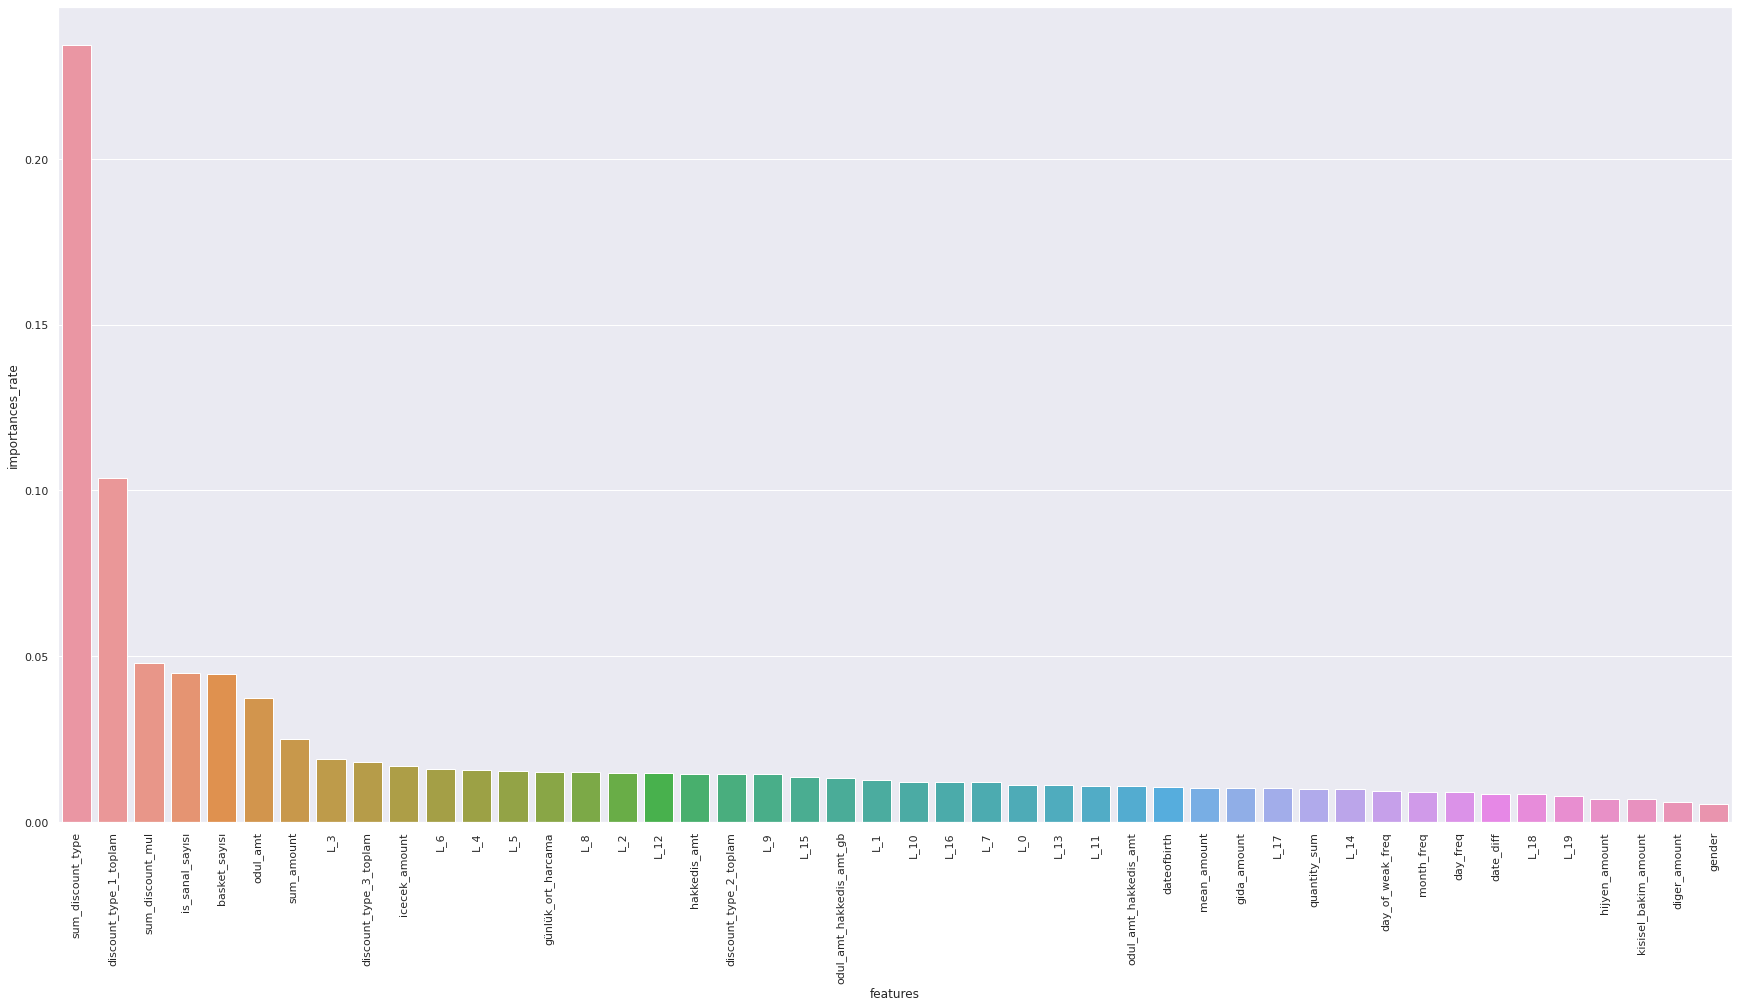

In [22]:
importances=pd.DataFrame([model.feature_importances_ for model in all_models]).mean(axis=0).values
dum=pd.DataFrame(data={'features':data_test.columns,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
#dum.features=dum.features.map(lambda x:  '_'.join(x) if type(x)==tuple else x)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(x=dum.features,y=dum.importances_rate)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [23]:
submission=test_id.to_frame()
submission['response']=pred
sample_submission=pd.read_csv('/kaggle/input/migros-datathon-coderspace/sample_submission.csv')
sample_submission=sample_submission[['individualnumber']].merge(submission,how='left',on='individualnumber').fillna(0)
sample_submission.response=sample_submission.response.astype(int)
sample_submission.set_index('individualnumber',drop=True,inplace=True)
sample_submission.to_csv('./migros_43.csv')
sample_submission

,response
individualnumber,
95812936,0
23929570,0
95948115,0
100898513,0
12769156,1
...,...
93418529,0
97397069,0
95212479,0


In [ ]:
# param={
# 'lambda': 2.465963549393914, 'alpha': 9.91601759481999, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 22, 'scale_pos_weight': 12.816243563454234,
#     'n_estimators': 5000,
#     'use_label_encoder':False,            
#     'eval_metric':'logloss',
#     "objective": "binary:logistic",
# #     'scale_pos_weight':70,
#     'tree_method':'gpu_hist',
# #     'early_stopping_rounds':100
# } 
# score_list1=[]
# kf = KFold(n_splits=3, shuffle=True, random_state = 34)
# folds=list(kf.split(data_train,target_train))
# train_losses=[]
# val_losses=[]
# thresholds=[]
# for train_index, test_index in folds:
#     X_train , X_val = data_train.iloc[train_index], data_train.iloc[test_index]  
#     y_train, y_val = target_train.iloc[train_index], target_train.iloc[test_index]  
#     val_set=[(X_train,y_train),(X_val, y_val)]

#     model = xgb.XGBClassifier(**param)  
#     model.fit(X_train,y_train, eval_set=val_set,verbose=False )
#     results = model.evals_result()
# #         val_pred=(np.where(model.predict(X_val) >= 0.5, 1, 0))
# #         f1score=f1_score(val_pred,y_val)     
    
#     preds = model.predict_proba(X_val)[:, 1]
#     threshold, val_score = calculate_optimum_threshold(y_val, preds)
    
#     f1score = classification_scores(y_val, preds, threshold=threshold)
# #     f1score=f1_score(val_scores,y_val)

# #         f1score=f1_score(val_pred,y_val)
#     score_list1.append( list(f1score.values())[0])
#     train_losses.append(results['validation_0']['logloss'])
#     val_losses.append(results['validation_1']['logloss'])
#     thresholds.append(threshold)
# print(np.mean(thresholds))
# train_loses=np.mean(train_losses,axis=0)
# val_loses=np.mean(val_losses,axis=0)

# # retrieve performance metrics
# results = model.evals_result()
# epochs = len(results['validation_0']['logloss'])
# x_axis = range(0, epochs)
# # plot log loss
# fig, ax = plt.subplots(figsize=(15, 10))
# ax.plot(x_axis, train_loses, label='Train');
# ax.plot(x_axis, val_loses, label='Validation');
# ax.legend();
# plt.ylabel('Log Loss');
# plt.title('XGBoost Log Loss');
# plt.xlabel('epocs');
# plt.show();